# Confirmation Bias Project
## Behavioural analyses
#### Experiment 3 CJ
In this version of the experiment (1.4) we wanted to compared the same subjects under repeated or similar sequences. We only presented 1 repetition and importantly, I also gathered the participants confidence in their response.mm

We recommend to run this script in Jupyter Notebook. It is possible to not visualize some plots in JupyterLab

__Metadprime is computed using the library from:__

pip install git+https://github.com/LegrandNico/metadPy.git

##### Import important functions and libraries

In [70]:
import os, glob
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
#import ptitprince as pt
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

R code implementation

In [71]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

##### Important functions

In [72]:
def RT_filter(x, sd): 
    # this function was used to filter those trials with a RT that are above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x #the same dataframe with RT filtered

def log_reg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    PSE = - reg.params.Intercept/reg.params[1]
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    return out #intercept + weight

def z_RT(x):
    # this function was used to calculate the z score of the RT values from a dataframe 
    rt_mean = x['RT'].mean()
    rt_sd   = x['RT'].std()
    x['RTz'] = (x['RT']- rt_mean)/rt_sd
    x['1/RTz']= 1/x['RT']
    rt_mean1  = x['1/RTz'].mean()
    rt_sd1    = x['1/RTz'].std()
    x['1/RTz']=(x['1/RTz']- rt_mean1)/rt_sd1
    return x

def z_DV(x):
    # this function was used to calculate the z score of the DV values from a dataframe 
    dv_mean = x['DV'].mean()
    dv_sd   = x['DV'].std()
    x['DVz'] = (x['DV']- dv_mean)/dv_sd
    return x

def cartesian(arrays, out=None):
    """
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

### Data & variables

In [163]:
# CAUTION !! 
# Change the current path to the folder where you stored the experimental results 


results_path = '/home/freeman/Insync/alexisperez@ub.edu/OneDrive Biz/PROJECTS/Condcision/Behav_data/Behavioral/condcisionCJ/' #

os.chdir(results_path) # change the current working directory to the results path 

all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations


nsubj = 0 # initialize subjects counter

for file in sorted(glob.glob("*.psydat")): 
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    pfile =  open(os.path.join(results_path, file),"rb")
    nsubj = nsubj + 1
    dat = pickle.load(pfile)
    for block in dat['main_exp']['Exp_blocks']:
        dvdata = pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])
        ddata = pd.concat([block['data'], dvdata, block['trial_orientations']], axis = 1)
        subjdata = pd.concat([subjdata, ddata], axis = 0)
    
    subjdata.insert(0, 'npar', nsubj)
    
    all_df = pd.concat([all_df, subjdata], axis = 0) #concatenate each new subject

all_df.head(10)


,npar,subj,nblock,ntrial,nrep,blocktype,trial_type,cond,DV,resp,r_map,correct,confi,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
0,1,s01,0,0,0,nonrepeat,False,1,0.08,1.0,45,1,0.10,2.044453,0.828372,-0.956710,0.360338,-0.087842,0.939380,-0.549273,0.718,0.017,2.105,1.929,2.380,0.177
1,1,s01,0,0,1,nonrepeat,False,1,0.08,1.0,0,1,0.35,2.114065,-0.186164,-0.022671,0.287481,0.530953,0.415324,-0.616519,2.822,1.187,2.636,2.172,1.015,2.991
2,1,s01,0,1,0,nonrepeat,False,-1,-0.01,1.0,45,-1,0.75,1.752747,0.840586,-0.430107,0.129599,0.858411,-0.717341,-0.844146,0.848,1.347,2.698,0.841,0.111,1.632
3,1,s01,0,1,1,nonrepeat,False,-1,-0.01,-1.0,45,1,-0.15,1.981836,-0.668958,0.911887,0.596642,0.846197,-0.812598,-0.861971,0.130,0.820,0.627,0.725,3.068,1.625
4,1,s01,0,2,0,nonrepeat,False,-1,-0.11,-1.0,45,1,0.40,2.481966,-0.637881,0.462198,-0.473916,0.087865,-0.446895,0.491718,1.713,2.145,2.935,1.998,1.788,0.985
5,1,s01,0,2,1,nonrepeat,False,-1,-0.11,1.0,45,-1,0.70,1.398619,-0.197340,0.444372,0.665916,-0.903752,0.329781,-0.864518,1.886,2.138,2.225,1.533,2.093,1.624
6,1,s01,0,3,0,nonrepeat,False,1,0.11,1.0,45,1,0.60,1.405562,0.519729,-0.601240,-0.049645,0.634840,0.319076,-0.260012,0.974,2.985,1.944,0.642,0.518,2.851
7,1,s01,0,3,1,nonrepeat,False,1,0.11,1.0,45,1,0.25,1.301392,0.518220,-0.770817,0.939380,0.513127,0.375617,-0.952654,2.167,0.090,2.380,2.165,2.111,3.123
8,1,s01,0,4,0,nonrepeat,False,-1,-0.01,-1.0,0,1,-0.10,3.336132,0.417352,-0.934829,-0.528901,-0.118918,0.922592,0.326197,2.585,3.116,0.185,0.346,0.755,1.050
9,1,s01,0,4,1,nonrepeat,False,-1,-0.01,1.0,45,-1,0.70,1.197235,0.397498,-0.783031,-0.578322,0.823279,-0.488158,0.678648,1.022,1.656,2.976,0.716,0.201,2.230


### Dataframe experiment 1: coding important variables

In [164]:
df = all_df.copy() # copy tge variable

# relabeling some variables
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

df.insert(5, 'cond-1', 0)    # 0 = previous Diag / 1 = previous Card
df['cond-1'] = df['cond'].shift(1, fill_value  = 0)

# Inserting deci variable
df.insert(9, 'deci', 0)
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(9, 'deci-1', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'corr-1', 0) # O = incorrect / 1 = correct
df.insert(7, 'rDV', 0) # rDV (real Decision Variable)
df.insert(10, 'deci-2', 0)    # 0 = 2 previous Diag / 1 = previous Card

# Recoding variables
df['deci-1'] = df['deci'].shift(1, fill_value  = 0) # deci in trial n-1
df['deci-2'] = df['deci-1'].shift(1, fill_value  = 0) # deci in trial n-2
df['corr-1'] = df['correct'].shift(1, fill_value  = 0) # correct in trial n-1


df['rDV'] = np.mean(df.iloc[:,20:26], axis = 1) # average DV
df.head(50)

## Eliminating inverted responses of some participants
df = df[~((df.subj == 's11') & (df.nblock == 1))]
df = df[~((df.subj == 's22') & (df.nblock == 1))]
df.reset_index(drop=True, inplace=True)

## df['nrep'] = df['nrep'].astype('category')
df['nblock'] = df['nblock'].astype('category')
df['cond-1'] = df['cond-1'].astype('category')
df['deci-1'] = df['deci-1'].astype('category')
df['deci-2'] = df['deci-2'].astype('category')



In [165]:
def split_confi(x):
    x.insert(19, 'conf_lvl', 'L')  
    s = np.median(x.confi)
    x.loc[s < x.confi, 'conf_lvl'] = 'H' 
    #x.insert(5, 'conf_mean', s) 
    return x

In [166]:
df = df.groupby(['subj', 'nrep','nblock']).apply(split_confi) # probably confidence changes as the experiment progresses
df.reset_index(inplace = True)

In [167]:
df.insert(21, 'conf_lvl-1', 0)    # 0 = previous Diag / 1 = previous Card
df['conf_lvl-1'] = df['conf_lvl'].shift(1, fill_value  = 'L')

In [95]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'PSE', within = ['nrep', 'deci-1'], subject = 'subj', 
            data=log_reg_preDeci, detailed = True, correction = True)

NameError: name 'log_reg_preDeci' is not defined

Correcting some subjects that commited mistakes by confusing the response option

Verifying that rDV does not changes across repetitions

In [168]:
dfs = df.copy()
dfs['rDV'] = np.abs(dfs['rDV'])
df_avgs = dfs.groupby(['subj','blocktype', 'nrep'],as_index=False)[['rDV', 'confi']].mean()
#Checking statistical differences in metadeprime between the number of repetitions & blocktype
pg.rm_anova(dv = 'rDV', within = ['nrep', 'blocktype'], subject = 'subj', 
            data=df_avgs, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.000002,1,30,0.000002,2.978406,0.094670,0.094670,0.090314,1.0
1,blocktype,0.002035,1,30,0.002035,0.283613,0.598266,0.598266,0.009365,1.0
2,nrep * blocktype,0.000002,1,30,0.000002,2.978406,0.094670,0.094670,0.090314,1.0


In [158]:
pg.rm_anova(dv = 'confi', within = ['nrep', 'blocktype'], subject = 'subj', 
            data=df_avgs, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.390173,1,30,0.390173,29.965578,0.000006,0.000006,0.499713,1.0
1,blocktype,0.004830,1,30,0.004830,0.672941,0.418499,0.418499,0.021939,1.0
2,nrep * blocktype,0.006271,1,30,0.006271,4.597497,0.040241,0.040241,0.132885,1.0


__Calculating mean DV and confi per condition__ 

Checking wether participants performed better in repeated or nonrepeated trials

## Calculating metadprime

In [56]:
#! pip install numpyro
import numpy as np
import arviz as az
import numpyro
from metadPy.bayesian import hmetad
#from metadPy import load_dataset

# Set the number of cores used by Numpyro here
numpyro.set_host_device_count(2)

/home/freeman/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/freeman/anaconda3/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [57]:
def hm_metad(x):
    model, traces = hmetad(
        data=x, 
        stimuli="cond",
        accuracy="correct",
        nRatings=8,
        confidence="confi",
        backend="numpyro")
    out = az.summary(traces, var_names=["meta_d"])
    #az.plot_trace(traces, var_names=["meta_d", "cS1", "cS2"]);
    return out

In [58]:
#df_test = df[(df.subj == 's01') | (df.subj == 's02')] # s16 does not converge
meta_dprimes = df.groupby(['subj', 'nrep','blocktype']).apply(hm_metad)
meta_dprimes.reset_index(inplace = True)

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()
Correcting for bias in high confidence ratings


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()
Correcting for bias in high confidence ratings


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The confidence columns contains more unique values than nRatingsThe ratings are going to be discretized using metadPy.utils.discreteRatings()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
dat = meta_dprimes
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==0)& (log_reg_cong_stim.blocktype=='nonrepeat')]
#dat =  log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "nrep"; dy = "mean"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col= 'blocktype', height= 5.5, aspect=.5,margin_titles=True) # col="nrep",
g.set(ylim=[-0.65,1.5], yticks=[-0.5, 0, 0.5, 1])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(['P1','P2'])
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Meta d'", fontsize = 15 )


NameError: name 'meta_dprimes' is not defined

In [18]:
#Checking statistical differences in metadeprime between the number of repetitions & blocktype
pg.rm_anova(dv = 'mean', within = ['nrep', 'blocktype'], subject = 'subj', 
            data=meta_dprimes, detailed = True, correction = True)

NameError: name 'meta_dprimes' is not defined

### Reaction Times 
##### Filter those responses with RTs larger than 4 sd

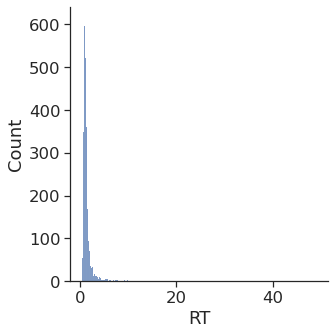

In [14]:
# RTs after apply filter
#df = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 4)
sns.displot(df.RT)

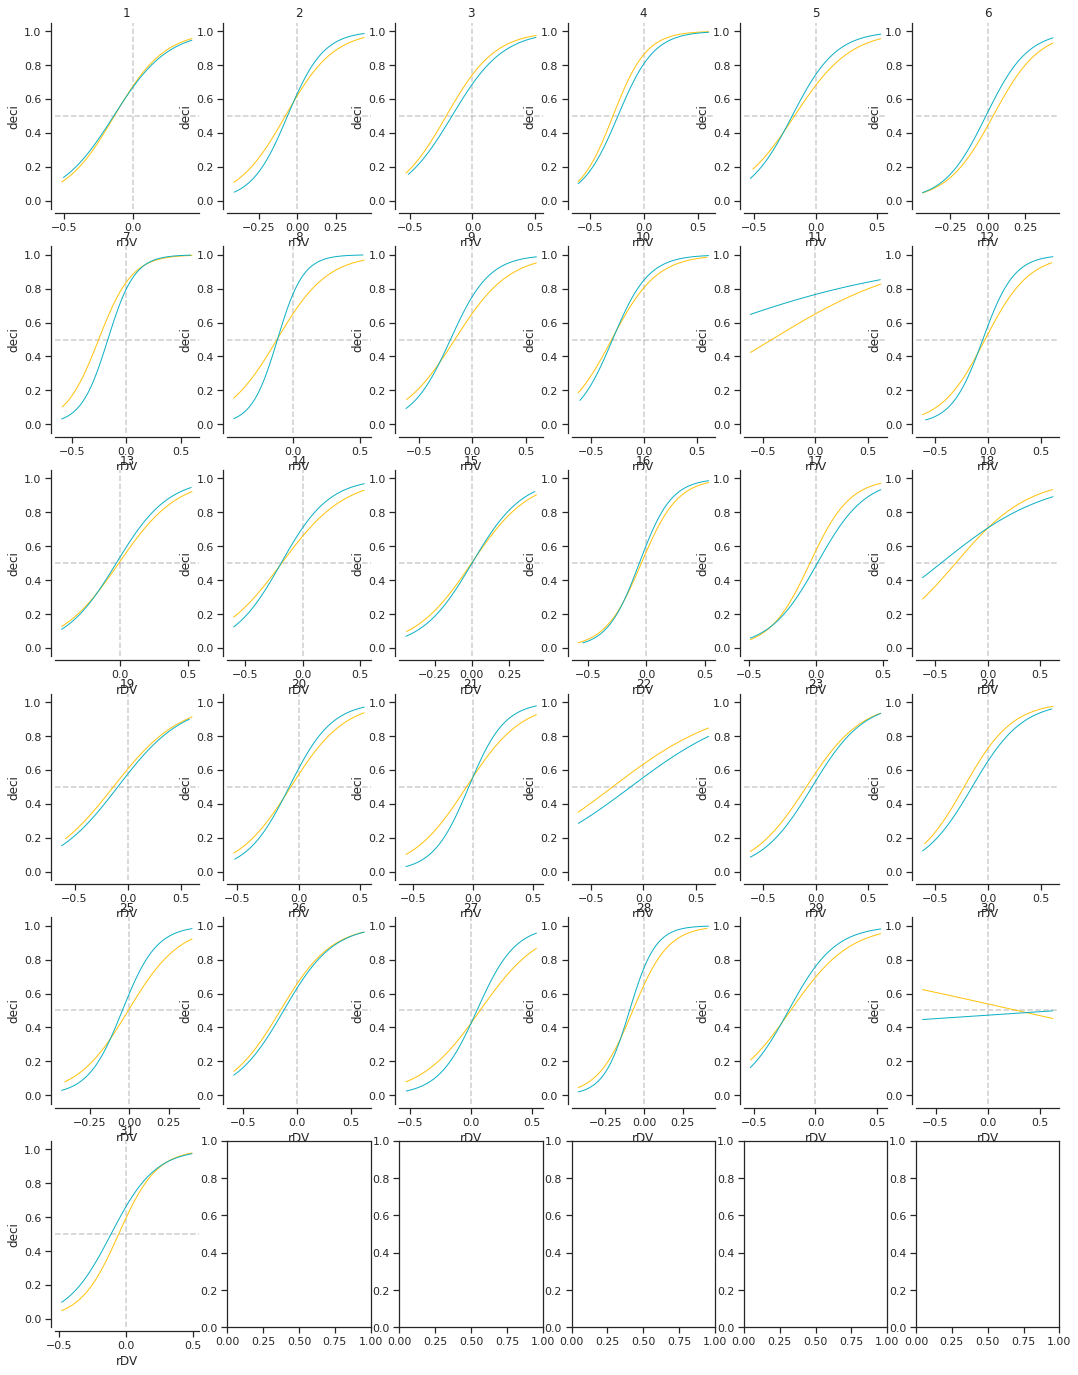

In [169]:
nprows = 6 
npcols = 6

nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar


fig, axes = plt.subplots(nprows, npcols, figsize=(18, 24))
#fig.tight_layout() # improving the space
p = cartesian((np.arange(0,nprows), np.arange(0,npcols)))

for i in npar_labels: #for loop to compute the average by each participant
    df2 = df.loc[df.npar == i,:]
    axes[p[i-1,0],p[i-1,1]].axvline(0, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].axhline(0.5, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].title.set_text(df2.iloc[0,1])
    sns.despine(ax=axes[p[i-1,0],p[i-1,1]],offset=4); # , trim=True
    for cell in nrep_labels:
            #sns.set_palette(mycol)
            sns.regplot(ax=axes[p[i-1,0],p[i-1,1]],x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                             line_kws ={'alpha':0.95, 'lw':1}); #mean all subject
    

#plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
#axes[1].plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
#axes[1].plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)

In [110]:
formula = "deci ~ rDV"
log_par = df.groupby(['subj']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True, drop= True)
log_par.head(5)
# here it seems that visual inspection shows that p13 and p15 were pretty bad

,intercept,weight,PSE
0,0.702635,5.232482,-0.134283
1,0.512323,7.294453,-0.070235
2,1.630167,6.120223,-0.266357
3,0.891883,4.883075,-0.182648
4,-0.074186,6.779085,0.010943


In [62]:
mean_w = np.mean(log_par.weight)
std_w  = np.std(log_par.weight)
log_par.weight > (mean_w + 2*std_w)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27     True
28    False
29    False
30    False
Name: weight, dtype: bool

### Removing bad participants

In [170]:
df = df.loc[(df.subj != 's03') & (df.subj != 's11')& (df.subj != 's30'),:] #she was very distracted and confused the keys
df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe

##### Dataset with good participants

In [100]:
estimations = (np.max(np.unique(df.ntrial)) + 1)* (np.max(np.unique(df.nblock)) + 1)
print("number of trials by participant was " + str(estimations))

number of trials by participant was 176


###### The original dataset was transformed to long format to perform some of the necessary analyses
 - It allows to perform reverse correlation analyses
 - We inserted new variables to this dataset

In [1923]:
df.head(5)

,index,npar,subj,nblock,ntrial,nrep,cond-1,blocktype,rDV,trial_type,cond,deci-2,deci-1,deci,corr-1,DV,resp,r_map,correct,confi,conf_lvl,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
0,0,1,s01,0,0,0,0,nonrepeat,0.089044,False,1,0,0,1,0,0.08,1.0,45,1,0.10,L,2.044453,0.828372,-0.956710,0.360338,-0.087842,0.939380,-0.549273,0.718,0.017,2.105,1.929,2.380,0.177
1,1,1,s01,0,0,1,1,nonrepeat,0.068067,False,1,0,1,1,1,0.08,1.0,0,1,0.35,H,2.114065,-0.186164,-0.022671,0.287481,0.530953,0.415324,-0.616519,2.822,1.187,2.636,2.172,1.015,2.991
2,2,1,s01,0,1,0,1,nonrepeat,-0.027166,False,0,1,1,1,1,-0.01,1.0,45,0,0.75,H,1.752747,0.840586,-0.430107,0.129599,0.858411,-0.717341,-0.844146,0.848,1.347,2.698,0.841,0.111,1.632
3,3,1,s01,0,1,1,0,nonrepeat,0.001867,False,0,1,1,0,0,-0.01,-1.0,45,1,-0.15,L,1.981836,-0.668958,0.911887,0.596642,0.846197,-0.812598,-0.861971,0.130,0.820,0.627,0.725,3.068,1.625
4,4,1,s01,0,2,0,0,nonrepeat,-0.086152,False,0,1,0,0,1,-0.11,-1.0,45,1,0.40,H,2.481966,-0.637881,0.462198,-0.473916,0.087865,-0.446895,0.491718,1.713,2.145,2.935,1.998,1.788,0.985


In [171]:
# df to long format
dflong = pd.melt(df, id_vars=['subj','blocktype','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','confi','conf_lvl','conf_lvl-1','RT'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['subj','blocktype','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','confi','conf_lvl','conf_lvl-1','RT'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
dflong.orient = np.rad2deg(dflong.orient) # transform to degrees
del out

dflong = dflong.sort_values(['nblock','subj','ntrial','nrep',],ascending=[True,True,True,True]) # reorder variables
dflong.reset_index(drop=True, inplace=True)
dflong.insert(5, "stim_cond", "D")
dflong.loc[(dflong.dv < 0), "stim_cond"]  = "C"


dflong.insert(7, 'cong_deci', "I") # if stim is congruent with previous repetition decosion category
# an stimuli is expected when the previous dv and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong['deci-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['deci-1'] == 1) & (dflong.stim_cond == 'D'), "cong_deci"]  = "C"



dflong.insert(8, 'cong_stim', 'I') # if stim is congruent with previous repetition mean category
dflong.loc[(dflong['cond-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['cond-1'] == 'D') & (dflong.stim_cond == 'D'), 'cong_stim'] = 'C'

# relabeling variables
#dflong["cond-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-2"].replace({0: "C", 1: "D"}, inplace=True)


dflong['ov'] = signal.sawtooth(2*np.deg2rad(dflong.orient), 0.5) # orientation variable (here I define an ov to make stimuli that differ by less of 45 degrees or more than 135 as similar)
# plt.scatter(dflong.orient,dflong['ov']) # see here


dflong.head(5)

,subj,blocktype,nblock,ntrial,nrep,stim_cond,cond-1,cong_deci,cong_stim,cond,deci-2,deci-1,deci,corr-1,correct,confi,conf_lvl,conf_lvl-1,RT,stim,dv,orient,ov
0,s01,nonrepeat,0,0,0,D,0,I,I,1,0,0,1,0,1,0.1,L,L,2.044453,d1,0.828372,41.138370,-0.085814
1,s01,nonrepeat,0,0,0,C,0,C,C,1,0,0,1,0,1,0.1,L,L,2.044453,d2,-0.956710,0.974028,-0.978355
2,s01,nonrepeat,0,0,0,D,0,I,I,1,0,0,1,0,1,0.1,L,L,2.044453,d3,0.360338,120.607616,0.319831
3,s01,nonrepeat,0,0,0,C,0,C,C,1,0,0,1,0,1,0.1,L,L,2.044453,d4,-0.087842,110.523559,0.543921
4,s01,nonrepeat,0,0,0,D,0,I,I,1,0,0,1,0,1,0.1,L,L,2.044453,d5,0.939380,136.363955,-0.030310


### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [172]:
# Adding decision variable difference & congruency between stim
out = np.diff(dflong.dv, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiffDV = out

stim_dec = dflong.dv.copy()
stim_dec = stim_dec.to_numpy()
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0
diffDV = np.absolute(np.diff(stim_dec, prepend = 0)) #  change = 1, repeated = 0

# Adding physical orientation variable difference & congruency between stim

out = np.diff(dflong.ov, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiff_stim_ori = out

stim_ori = dflong.ov.copy()
stim_ori = stim_ori.to_numpy()
# Simplify the labels
stim_ori[stim_ori > 0] = 1
stim_ori[stim_ori < 0] = 0
diffstim_ori= np.absolute(np.diff(stim_ori, prepend = 0))


# Merging all the datasets
dflong_seq = pd.concat([dflong, pd.Series(absdiffDV, dtype=np.int32, name='abs_diffDV'), pd.Series(diffDV, dtype=np.int32, name='cong_stim_DV'),pd.Series(stim_ori, dtype=np.int32, name='stim_cat_OV'),pd.Series(stim_ori, dtype=np.int32, name='abs_diffOV'), pd.Series(diffstim_ori, dtype=np.int32, name='cong_stim_OV')], axis=1).copy()

dflong_seq = dflong_seq.loc[dflong_seq['stim'] != "d1"] # now I remove d1 as it is not informative and it would add noise to this analysis
dflong_seq.head(2)

,subj,blocktype,nblock,ntrial,nrep,stim_cond,cond-1,cong_deci,cong_stim,cond,deci-2,deci-1,deci,corr-1,correct,confi,conf_lvl,conf_lvl-1,RT,stim,dv,orient,ov,abs_diffDV,cong_stim_DV,stim_cat_OV,abs_diffOV,cong_stim_OV
1,s01,nonrepeat,0,0,0,C,0,C,C,1,0,0,1,0,1,0.1,L,L,2.044453,d2,-0.956710,0.974028,-0.978355,1.785082,1,0,0,0
2,s01,nonrepeat,0,0,0,D,0,I,I,1,0,0,1,0,1,0.1,L,L,2.044453,d3,0.360338,120.607616,0.319831,1.317048,1,1,1,1


## Plots experiment 1

<font size="5"> _Figure 2A. Logistic regression fit for each presentation._

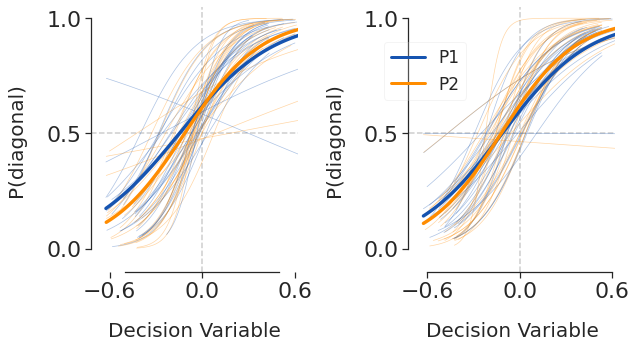

In [173]:
mycol = ["#1654B0", "darkorange"]
sns.set_palette(mycol)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar
blocktype_labels = np.unique(df.blocktype) 
 

for j in [0,1]: #for loop to compute the average by each participant
    axes[j].axvline(0, ls='--', color= 'black', alpha=0.2)
    axes[j].axhline(0.5, ls='--', color= 'black', alpha=0.2)
    
    for i in npar_labels: #for loop to compute the average by each participant
        df2=df.loc[(df.npar == i) & (df.blocktype == blocktype_labels[j]) ,:]
        for cell in nrep_labels:
            sns.set_palette(mycol)
            sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1, ax = axes[j], label=cell,  truncate=True, 
                             line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject

    for cell in nrep_labels: #for loop to compute the plot by the average sample
        sns.set_palette(mycol)
        sns.regplot(x="rDV", y="deci",  data=df.loc[(df.nrep == cell) & (df.blocktype == blocktype_labels[j]),:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,   ax = axes[j], label=cell,  truncate=True, 
                         line_kws ={'lw':3.4});
    #sns.despine(offset=1, trim=True, ax = axes[j]);
    sns.despine(ax= axes[j], offset=0.5, trim = True);
    
    axes[j].set_ylabel('P(diagonal)', fontsize = 20, labelpad=20); #axes[j].set_yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
    axes[j].set_xlabel('Decision Variable', fontdict={'size':20}, labelpad=20); 
    
    #xticks = [-0.6,-0.3,0,0.3,0.6] #np.round(np.arange(-0.9, 0.6, step=0.3),decimals = 2)
    #yticks = np.arange(-0., 1.1, step=0.25)
    
    axes[j].set_xlim(-0.72,0.62)
    axes[j].set_xticks([-0.6,0,0.6]) 
    
    axes[j].tick_params(axis='x', labelsize=22)   
    axes[j].set_yticks([0.0,0.5,1]) 
    axes[j].set_ylim(-0.1,1.05)
    axes[j].tick_params(axis='y', labelsize=22) 
   
  
    lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2']; 
    plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
    fig.tight_layout()
    #plt.savefig('deci_x_nrep.png',bbox_inches='tight')


<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with number of presentation

In [174]:
# make the model to estimate if there are statistical differences in weight or the intercept
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['subj', 'nrep', 'blocktype']).apply(log_reg_fit, formula) 
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.tail(5)

,subj,nrep,blocktype,level_3,intercept,weight,PSE
107,s31,1,repeat,0,-0.140042,-0.191412,-0.731627
108,s32,0,nonrepeat,0,0.478246,13.850652,-0.034529
109,s32,0,repeat,0,0.353634,4.998314,-0.070751
110,s32,1,nonrepeat,0,0.732737,9.467787,-0.077393
111,s32,1,repeat,0,0.660708,4.884401,-0.135269


<font size="4"> _Statistical tests for Weight._

In [175]:
dat = log_reg_nrep
aov = AnovaRM(dat, 'weight', 'subj', within=['nrep', 'blocktype'])
resaov = aov.fit()
print(resaov) 

                   Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
nrep           11.2590 1.0000 27.0000 0.0024
blocktype       0.3006 1.0000 27.0000 0.5880
nrep:blocktype  0.5247 1.0000 27.0000 0.4751



In [176]:
dat = log_reg_nrep
aov = AnovaRM(dat, 'PSE', 'subj', within=['nrep', 'blocktype'])
resaov = aov.fit()
print(resaov) 

                   Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
nrep            0.1955 1.0000 27.0000 0.6619
blocktype       1.2830 1.0000 27.0000 0.2673
nrep:blocktype  3.9158 1.0000 27.0000 0.0581



In [25]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()  # make pyr2 accept and auto-convert pandas dataframes
from rpy2.robjects.packages import importr
base = importr('base')
ez = importr('ez')
robjects.r['options'](warn=-1)  # ???


/home/freeman/anaconda3/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


warn,[RTYPES.INTSXP]


In [117]:
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep','blocktype'], subject = 'subj', data=log_reg_nrep, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,52.819985,1,27,52.819985,11.259033,0.002364,0.002364,0.294284,1.0
1,blocktype,2.800855,1,27,2.800855,0.300612,0.588004,0.588004,0.011011,1.0
2,nrep * blocktype,1.981451,1,27,1.981451,0.524714,0.475068,0.475068,0.019063,1.0


In [737]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within='nrep', subject='npar', padjust='bonf', 
                   tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

TypeError: pairwise_ttests() got an unexpected keyword argument 'tail'

In [118]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'PSE', within = ['nrep','blocktype'], subject = 'subj', data=log_reg_nrep, 
            detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.001857,1,27,0.001857,0.195549,0.661860,0.661860,0.007190,1.0
1,blocktype,0.023083,1,27,0.023083,1.283015,0.267298,0.267298,0.045363,1.0
2,nrep * blocktype,0.020228,1,27,0.020228,3.915810,0.058117,0.058117,0.126660,1.0


In [120]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within='nrep', subject='npar', padjust='bonf', 
                    effsize = 'cohen', data=log_reg_nrep) 

KeyError: 'npar'

In [ ]:
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep','blocktype'], subject = 'subj', data=log_reg_nrep, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,49.469258,1,22,49.469258,9.842812,0.004788,0.004788,0.309106,1.0
1,blocktype,0.024789,1,22,0.024789,0.003943,0.950496,0.950496,0.000179,1.0
2,nrep * blocktype,3.869457,1,22,3.869457,1.039750,0.318963,0.318963,0.045129,1.0


# Parameters
Plotting weights and PSE

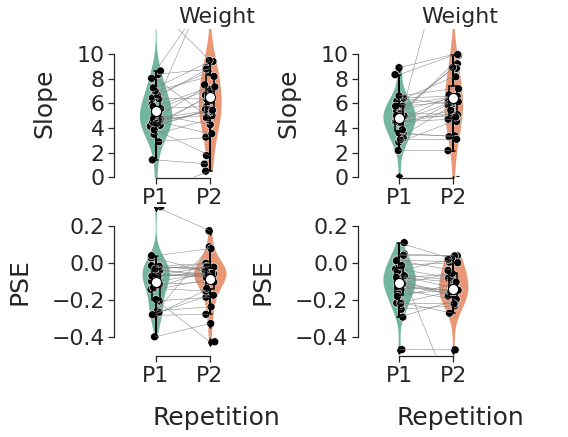

In [177]:
sns.set(style="ticks",font_scale=2)

dat = log_reg_nrep
ort = "v"; 
pal = "Set2"
dx = "nrep"; dy = "weight"; ort = "v"; pal = pal; sigma = .5
f, axes = plt.subplots(2,2,figsize=(8, 6))

# PLOTTING INTERCEPT

 
for j in [0,1]: #for loop to compute the average by each participant

    dat = log_reg_nrep[log_reg_nrep.blocktype == blocktype_labels[j]]
    
    sns.boxplot( x = dx, y = dy, data = dat, color = "black"
          ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.1, orient = ort, ax = axes[0,j])

    sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
          edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[0,j])

    sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
         bw = 0.5, cut = 0.0,scale = "area", width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0,j])

    sns.lineplot(x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[0,j])


    axes[0,j].set_xlim([-0.75, 3])
    axes[0,j].set_xticks([0,1])
    axes[0,j].set_xticklabels(['P1','P2'])
    axes[0,j].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 


    axes[0,j].set_ylim([0, 12])
    axes[0,j].set_yticks(np.arange(0, 12, step=2))
    axes[0,j].set_ylabel('Slope', fontsize = 25, labelpad=20);

    axes[0,j].tick_params(axis='x', labelsize=22) 
    axes[0,j].tick_params(axis='y', labelsize=22)  
    axes[0,j].set_title('Weight',fontsize = 22)
    sns.despine(offset = 1,  trim=True, ax = axes[0,j]);
    
for j in [0,1]: #for loop to compute the average by each participant

    dat = log_reg_nrep[log_reg_nrep.blocktype == blocktype_labels[j]]    
# NOW I PLOT THE INTERCEPT
    dy = "PSE"
    #dy = "intercept"

    sns.boxplot( x = dx, y = dy, data = dat, color = "black"
          ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.1, orient = ort, ax = axes[1,j])

    sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
          edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[1,j])

    sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
         bw = 0.5, cut = 0.0,scale = "area", width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[1,j])

    #ax = sns.pointplot(x= dx, y= dy, data=dat, color = 'grey', errwidth = 0, size = 10, join = False, zorder = 8)
    sns.lineplot(x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[1,j])


    axes[1,j].set_xlim([-0.75, 3])
    axes[1,j].set_xticks([0,1])
    axes[1,j].set_xticklabels(['P1','P2'])
    axes[1,j].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 

    axes[1,j].set_ylim([-0.5, 0.3])
    axes[1,j].set_yticks(np.arange(-0.4, 0.2, step=0.2))
    axes[1,j].set_ylabel('PSE', fontsize = 25, labelpad=20);

    axes[1,j].tick_params(axis='x', labelsize=22) 
    axes[1,j].tick_params(axis='y', labelsize=22)  
    #axes[1].set_title('PSE',fontsize = 22)
    sns.despine(offset = 1,  trim=True, ax = axes[1,j]);


<font size="5"> _Figure 3A. Logistic regression fits for each presentation separated by cardinal & diagonal._

## Effect of previous decision in the current trial decision

In [178]:
formula = "deci ~ rDV"

subjs = np.array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11','s12', 's13', 's14', 's15', 's17', 's19', 's20',
       's21', 's23', 's24', 's25'])
for isub in subjs:
    df_subj = df[df.subj == isub] # s16 does not converge
    log_reg_preDeci = df_subj.groupby(['nrep', 'deci-1','blocktype']).apply(log_reg_fit, formula)
    
    

In [123]:
formula = "deci ~ rDV"

df_all = df[(df.subj != 's16') & (df.subj != 's22') &  (df.subj != 's10')] # s16 does not converge
log_reg_preDeci = df_all.groupby(['subj', 'nrep', 'deci-1','blocktype']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
#log_reg_preDeci.head(8)

log_reg_preDeci[(log_reg_preDeci.weight < 0)] # negative weights indicate a problem

,subj,nrep,deci-1,blocktype,level_4,intercept,weight,PSE
184,s31,0,0,nonrepeat,0,0.853585,-1.766782,0.483130
186,s31,0,1,nonrepeat,0,-0.046143,-0.779682,-0.059182
187,s31,0,1,repeat,0,0.149552,-0.492976,0.303366
189,s31,1,0,repeat,0,0.182082,-0.016180,11.253302
191,s31,1,1,repeat,0,-0.474604,-0.381025,-1.245598


In [33]:
np.unique(df_subj.subj)

array(['s25'], dtype=object)

/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


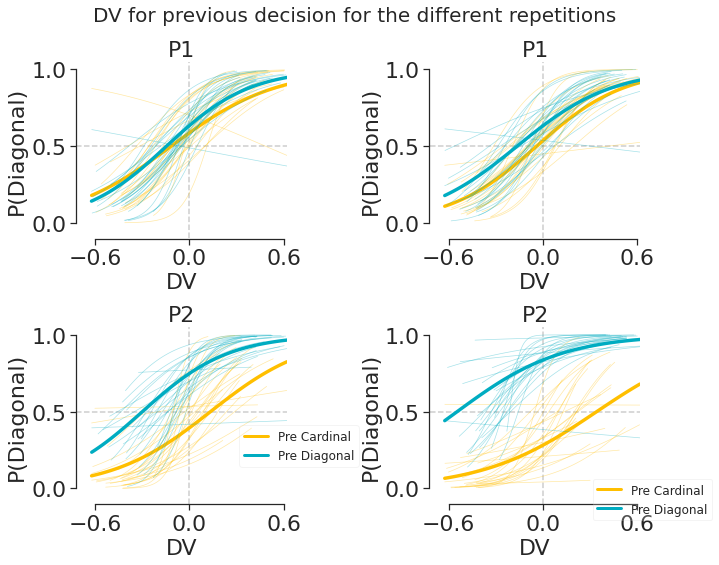

In [179]:
sns.set(font_scale = 1, style = 'ticks') 
mycol = ['#ffbf00' , '#00acc1'] #cardinal #diagonal
sns.set_palette(mycol)

titles = ['P1', 'P2']
pre_deci_labels = np.unique(df['deci-1'])     #pre_deci
nreps = np.unique(df['nrep'])     #nreps


df_subj = df[(df.subj != 's16') & (df.subj != 's10') & (df.subj != 's22') ] # s16 does not converge amd the others have negative weights
#df_subj = df[df.subj != 's22'] # s16 does not converge
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("DV for previous decision for the different repetitions", fontsize=20)

blocktype_labels = np.unique(df.blocktype) 
 

for z in [0, 1]: #for loop to compute the average by each participant
    
    for j in nreps:
        axes[j,z].axvline(0, ls='--', color= 'black', alpha = 0.2)
        axes[j,z].axhline(0.5, ls='--', color= 'black', alpha = 0.2)
        for cell in pre_deci_labels:
            for i in npar_labels: #this for loop makes the plot for each participant 
                dati = df_subj[(df_subj.npar == i) & (df_subj['deci-1'] == cell) & (df_subj.nrep == j) & (df_subj.blocktype == blocktype_labels[z])].copy()#df.loc[(df.npar == i) & (df['deci-1'] == cell) & (df.nrep == j),:]
                sns.regplot(x="rDV", y="deci",  data= dati,
                   logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                                  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7}, ax = axes[j,z], color = mycol[cell]);
            
            dat = df_subj[(df_subj['deci-1'] == cell) & (df_subj.nrep == j) & (df_subj.blocktype == blocktype_labels[z])].copy()
            sns.regplot(x="rDV", y="deci",  data= dat,
                   logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                              label=cell, truncate=True, line_kws={'lw':3.4}, ax = axes[j,z], color = mycol[cell]);

        # Tweaking subplots
        axes[j,z].set_title(titles[j],fontsize = 22)

        axes[j,z].set_xlabel('DV', fontsize = 22)
        axes[j,z].set_ylabel('P(Diagonal)', fontsize = 22)

        axes[j,z].set_xlim(-0.72,0.62)
        axes[j,z].set_xticks([-0.6,0,0.6]) 

        axes[j,z].tick_params(axis='x', labelsize=22)   
        axes[j,z].set_yticks([0.0,0.5,1]) 
        axes[j,z].set_ylim(-0.1,1.05)
        axes[j,z].tick_params(axis='y', labelsize=22) 
        #axes[j].xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); 
        sns.despine(ax= axes[j,z], offset=0.5, trim = True);

    labels = ['Pre Cardinal', 'Pre Diagonal']; 
    lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
    axes[1,z].legend(lines, labels, bbox_to_anchor=(0.745,0.175), fontsize=12, framealpha= 0.2)

    #plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold", 
    #         horizontalalignment="left")       
            #fig[j].title('P1', fontsize= 35); 
    
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.tight_layout()
#axes[0].ylabel('p(diagonal)', fontsize = 20, labelpad=20); axes[0].yticks(np.arange(0, 1.1, step=0.25), fontsize = 25); plt.xlabel(' ', fontsize = 0)


<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with previous decision by each presentation

In [35]:
np.unique(df.subj)

array(['s01', 's02', 's04', 's05', 's06', 's07', 's08', 's09', 's10',
       's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20',
       's21', 's22', 's23', 's24', 's25'], dtype=object)

In [183]:
formula = "deci ~ rDV"
#df_subj = df[df.subj != 's11'] # s16 does not converge
#df_subj = df[(df.subj != 's16') & (df.subj != 's22')] # s16 does not converge
#df_subj = df[df.subj != 's22'] # s16 does not converge
#df_subj = df[df.subj != 's18'] # s16 does not converge
log_reg_preDeci = df_subj.groupby(['subj', 'nrep', 'deci-1','blocktype']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head(8)

,subj,nrep,deci-1,blocktype,level_4,intercept,weight,PSE
0,s01,0,0,nonrepeat,0,1.384749,5.941368,-0.233069
1,s01,0,0,repeat,0,0.418740,4.445863,-0.094186
2,s01,0,1,nonrepeat,0,0.393566,5.215287,-0.075464
3,s01,0,1,repeat,0,0.872689,6.843830,-0.127515
4,s01,1,0,nonrepeat,0,0.817197,7.341192,-0.111317
5,s01,1,0,repeat,0,-0.717912,2.169722,0.330878
6,s01,1,1,nonrepeat,0,0.438794,3.174098,-0.138242
7,s01,1,1,repeat,0,3.665103,12.437501,-0.294682


In [37]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'deci-1'], subject = 'subj', 
            data=log_reg_preDeci, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,2.295391,1,19,2.295391,0.408504,0.530360,0.530360,0.021048,1.0
1,deci-1,12.234385,1,19,12.234385,4.154199,0.055697,0.055697,0.179414,1.0
2,nrep * deci-1,7.365477,1,19,7.365477,1.811107,0.194216,0.194216,0.087026,1.0


In [139]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'PSE', within = ['nrep', 'deci-1'], subject = 'subj', 
            data=log_reg_preDeci, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.195451,1,24,0.195451,0.494651,0.488627,0.488627,0.020194,1.0
1,deci-1,6.098848,1,24,6.098848,17.662558,0.000315,0.000315,0.423943,1.0
2,nrep * deci-1,4.824887,1,24,4.824887,16.439887,0.000459,0.000459,0.406527,1.0


In [180]:
mean = np.mean(log_reg_preDeci.PSE)
std = np.std(log_reg_preDeci.PSE)
s = log_reg_preDeci[(log_reg_preDeci.PSE > qh)]
s.head(50)
#log_reg_preDeci.PSE.head(60)

NameError: name 'qh' is not defined

In [141]:
mean = np.mean(log_reg_preDeci.PSE)
std = np.std(log_reg_preDeci.PSE)
s = log_reg_preDeci[(log_reg_preDeci.PSE < ql)]
s.head()

NameError: name 'ql' is not defined

In [1133]:
log_reg_preDeci[(log_reg_preDeci.PSE < ql)]

,subj,nrep,deci-1,blocktype,level_4,intercept,weight,PSE
76,s10,1,0,nonrepeat,0,-0.607763,-0.004937,-123.110723
118,s17,1,1,nonrepeat,0,1.218547,0.272226,-4.476241


(array([  2.,   2., 179.,  13.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([-4.47624082, -2.90328655, -1.33033228,  0.24262199,  1.81557626,
         3.38853053,  4.9614848 ,  6.53443907,  8.10739334,  9.68034761,
        11.25330188]),
 <BarContainer object of 10 artists>)

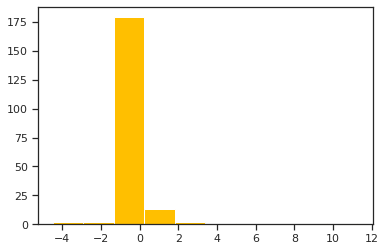

In [130]:
plt.hist(log_reg_preDeci.PSE)

In [184]:
dat = log_reg_preDeci[log_reg_preDeci.nrep == '1']
pg.pairwise_ttests(dv='PSE', within= ['deci-1'], subject='subj', interaction=True, effsize = 'cohen', data=dat) 

ValueError: Columns must have at least two unique values.

In [134]:
dat = log_reg_preDeci.loc[log_reg_preDeci['deci-1'] == 1]
pg.ttest(dat['PSE'], 0)

AssertionError: x must have more than one element.

In [182]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci[(log_reg_preDeci.nrep == 1) & (log_reg_preDeci.blocktype == 'repeat')] #cardinal
pg.pairwise_ttests(dv='PSE', within= ['deci-1'], subject='subj', padjust='bonf', 
                   interaction=False, effsize = 'cohen', data=dat) 

AttributeError: 'DataFrame' object has no attribute 'nrep'

In [185]:
 sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
          edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[0,j])

    sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
         bw = 0.5, cut = 0.0,scale = "area", width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0,j])

    sns.lineplot(x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[0,j])


IndentationError: unexpected indent (3635699559.py, line 5)

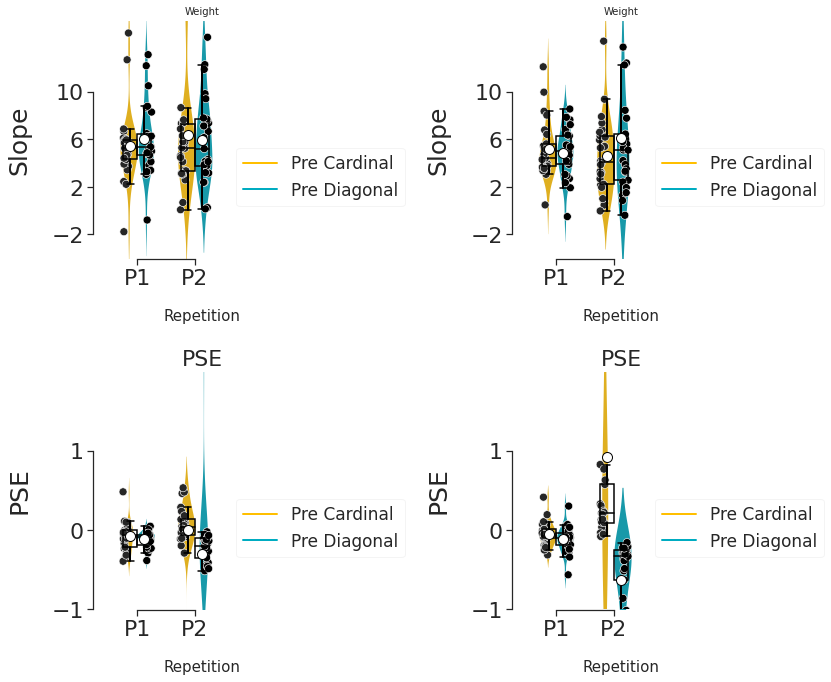

In [186]:
sns.set(style="ticks",font_scale=2)
mycol = ['#ffbf00' , '#00acc1'] 
dat = log_reg_nrep
ort = "v"; 
pal = "Set2"
dx = "nrep"; ort = "v"; pal = pal; sigma = .5
f, axes = plt.subplots(2,2,figsize=(12, 10))


for j in [0,1]: #for loop to compute the average by each participant
    
    dy = "weight"
    
    dat = log_reg_preDeci[log_reg_preDeci.blocktype == blocktype_labels[j]]
    
    ax0 = sns.boxplot( x = dx, y = dy, data = dat, hue = "deci-1", color = 'black'
          ,width = .5, zorder = 2, showcaps = True,  showmeans=True, meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=False,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.7, orient = ort, ax = axes[0,j])      
    
    ax = sns.stripplot(x = dx, y = dy, data = dat,  hue = "deci-1", color = "black",  dodge=True,
         edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[0,j])   
    
    ax1 = sns.violinplot( x = dx, y = dy, data = dat ,  hue = "deci-1", palette = mycol, 
                
         bw = 0.5, cut = 2, width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0,j])
    

    lines = [Line2D([0], [0], color=c, linewidth=2) for c in mycol]; 
    ax1.legend(lines, labels, bbox_to_anchor=(0.62,0.5), fontsize=17, framealpha= 0.2)
    f.tight_layout()

    
    axes[0,j].set_xlim([-0.75, 3])
    axes[0,j].set_xticks([0,1])
    axes[0,j].set_xticklabels(['P1','P2'])
    axes[0,j].set_xlabel('Repetition', fontdict={'size':15}, labelpad=20); 


    axes[0,j].set_ylim([-4, 16])
    axes[0,j].set_yticks(np.arange(-2, 14, step=4))
    axes[0,j].set_ylabel('Slope', fontsize = 25, labelpad=20);

    axes[0,j].tick_params(axis='x', labelsize=22) 
    axes[0,j].tick_params(axis='y', labelsize=22)  
    axes[0,j].set_title('Weight',fontsize = 10)
    sns.despine(offset = 1,  trim=True, ax = axes[0,j]);


for j in [0,1]: #for loop to compute the average by each participant
    
    dy = "PSE"
    
    dat = log_reg_preDeci[log_reg_preDeci.blocktype == blocktype_labels[j]]
    
    ax0 = sns.boxplot( x = dx, y = dy, data = dat, hue = "deci-1", color = 'black'
          ,width = .5, zorder = 2, showcaps = True,  showmeans=True, meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=False,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.7, orient = ort, ax = axes[1,j])
    
    
    
    ax = sns.stripplot(x = dx, y = dy, data = dat,  hue = "deci-1", color = "black",  dodge=True,
         edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[1,j])
   
    
    ax1 = sns.violinplot( x = dx, y = dy, data = dat ,  hue = "deci-1", palette = mycol, 
                
         bw = 0.5, cut = 2, width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[1,j])
    
    
    lines = [Line2D([0], [0], color=c, linewidth=2) for c in mycol]; 
    ax1.legend(lines, labels, bbox_to_anchor=(0.62,0.5), fontsize=17, framealpha= 0.2)
    f.tight_layout()
   
    axes[1,j].set_xlim([-0.75, 3])
    axes[1,j].set_xticks([0,1])
    axes[1,j].set_xticklabels(['P1','P2'])
    axes[1,j].set_xlabel('Repetition', fontdict={'size':15}, labelpad=20); 


    axes[1,j].set_ylim([-1, 2])
    axes[1,j].set_yticks(np.arange(-1, 2, step=1))
    axes[1,j].set_ylabel('PSE', fontsize = 25, labelpad=20);

    axes[1,j].tick_params(axis='x', labelsize=22) 
    axes[1,j].tick_params(axis='y', labelsize=22)  
    axes[1,j].set_title('PSE',fontsize = 22)
    sns.despine(offset = 1,  trim=True, ax = axes[1,j]);

Calculating the difference between deci-1 to simplify the plotting

In [187]:
diff_preDeci = log_reg_preDeci[log_reg_preDeci['deci-1'] == 1].copy()
diff_preDeci.reset_index(inplace = True, drop = True)
s = log_reg_preDeci[log_reg_preDeci['deci-1'] == 0].iloc[:,[5,6,7]].copy()
s.reset_index(inplace = True, drop = True)

diff_preDeci.iloc[:,[5,6,7]] = diff_preDeci.iloc[:,[5,6,7]] - s

In [322]:
diff_preDeci.head()

,subj,blocktype,nrep,deci-1,level_4,intercept,weight,PSE
0,s01,nonrepeat,0,1,0,-1.022640,-0.814957,0.162433
1,s01,nonrepeat,1,1,0,-0.378403,-4.167094,-0.026925
2,s01,repeat,0,1,0,0.453950,2.397967,-0.033328
3,s01,repeat,1,1,0,4.383015,10.267779,-0.625559
4,s02,nonrepeat,0,1,0,0.101309,-0.395168,-0.019829


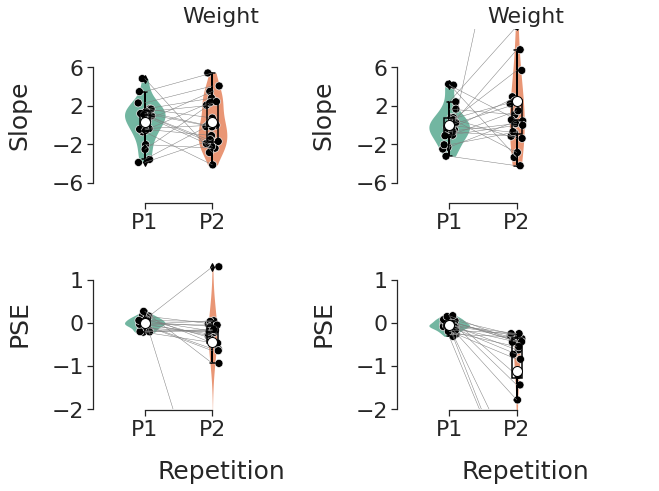

In [43]:
sns.set(style="ticks",font_scale=2)

dat = log_reg_nrep
ort = "v"; 
pal = "Set2"
dx = "nrep"; dy = "weight"; ort = "v"; pal = pal; sigma = .5
f, axes = plt.subplots(2,2,figsize=(10, 7))

# PLOTTING INTERCEPT

 
for j in [0,1]: #for loop to compute the average by each participant

    dat = diff_preDeci[diff_preDeci.blocktype == blocktype_labels[j]]
    
    sns.boxplot( x = dx, y = dy, data = dat, color = "black"
          ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.1, orient = ort, ax = axes[0,j])

    sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
          edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[0,j])

    sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
         bw = 0.5, cut = 0.0,scale = "area", width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0,j])

    sns.lineplot(x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[0,j])


    axes[0,j].set_xlim([-0.75, 3])
    axes[0,j].set_xticks([0,1])
    axes[0,j].set_xticklabels(['P1','P2'])
    axes[0,j].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 


    axes[0,j].set_ylim([-8, 10])
    axes[0,j].set_yticks(np.arange(-6, 10, step=4))
    axes[0,j].set_ylabel('Slope', fontsize = 25, labelpad=20);

    axes[0,j].tick_params(axis='x', labelsize=22) 
    axes[0,j].tick_params(axis='y', labelsize=22)  
    axes[0,j].set_title('Weight',fontsize = 22)
    sns.despine(offset = 1,  trim=True, ax = axes[0,j]);
    
for j in [0,1]: #for loop to compute the average by each participant

    dat = diff_preDeci[diff_preDeci.blocktype == blocktype_labels[j]]    
# NOW I PLOT THE INTERCEPT
    dy = "PSE"
    #dy = "intercept"

    sns.boxplot( x = dx, y = dy, data = dat, color = "black"
          ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.1, orient = ort, ax = axes[1,j])

    sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
          edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[1,j])

    sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
         bw = 0.5, cut = 0.0,scale = "area", width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[1,j])

    #ax = sns.pointplot(x= dx, y= dy, data=dat, color = 'grey', errwidth = 0, size = 10, join = False, zorder = 8)
    sns.lineplot(x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[1,j])


    axes[1,j].set_xlim([-0.75, 3])
    axes[1,j].set_xticks([0,1])
    axes[1,j].set_xticklabels(['P1','P2'])
    axes[1,j].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 

    axes[1,j].set_ylim([-2, 2])
    axes[1,j].set_yticks(np.arange(-2, 2, step=1))
    axes[1,j].set_ylabel('PSE', fontsize = 25, labelpad=20);

    axes[1,j].tick_params(axis='x', labelsize=22) 
    axes[1,j].tick_params(axis='y', labelsize=22)  
    #axes[1].set_title('PSE',fontsize = 22)
    sns.despine(offset = 1,  trim=True, ax = axes[1,j]);


In [44]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci.loc[log_reg_preDeci['deci-1'] == 1] #diagonal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

TypeError: pairwise_ttests() got an unexpected keyword argument 'tail'

<font size="5"> _Figure 3B. Beta weight by presentation and condition._

<font size="5"> _Figure 3C. PSE by presentation and condition._

<font size="5"> _Figure 4A. Beta Weight by presentation and sample._

<font size="4"> Statistical tests for Weight

In [532]:
# ANOVA to check if weight depends on the position of the stimuli sample: recency and primacy bias

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', 
            data=log_regstim_params, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.626836,1,21,0.626836,16.347753,0.000586,0.000586,0.437717,1.000000
1,stim,1.692184,5,105,0.338437,2.576133,0.030647,0.066000,0.109269,0.561484
2,nrep * stim,0.608702,5,105,0.121740,1.713102,0.137959,0.145427,0.075424,0.907859


In [42]:
log_regstim_params

,npar,nrep,stim,level_3,intercept,weight,PSE
0,1,0,d1,0,-0.913563,-1.029562,-0.887331
1,1,0,d2,0,-0.883891,-0.910509,-0.970765
2,1,0,d3,0,-0.871265,-0.733091,-1.188482
3,1,0,d4,0,-0.863337,-0.799175,-1.080286
4,1,0,d5,0,-0.816901,-0.648715,-1.259261
...,...,...,...,...,...,...,...
463,29,2,d2,0,-0.342614,-0.320535,-1.068882
464,29,2,d3,0,-0.358326,-0.424277,-0.844557
465,29,2,d4,0,-0.374224,-0.598483,-0.625288
466,29,2,d5,0,-0.334473,-0.521094,-0.641866


In [188]:
dflong_clean = dflong[(dflong.subj != 's16') & (dflong.subj != 's22') &  (dflong.subj != 's10')]
formula = "deci ~ dv"
log_regstim_params = dflong_clean.groupby(['subj','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)


<font size="2"> _t-test showed that discriminabilty was larger in the third sample than in the first one._

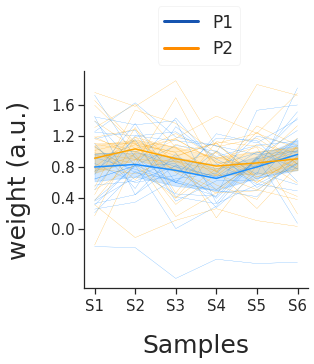

In [189]:
plt.subplots(ncols = 1, figsize = (4,4))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.subj)#npar

mycol = ["#1654B0", "darkorange"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.subj ==i,:]
    sns.lineplot(x="stim", y="weight", hue="nrep", 
                 palette= ["dodgerblue", "orange"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Intercept', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="weight", hue="nrep",
             palette= ["dodgerblue", "orange"], data=log_regstim_params)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('weight (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) 
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2']; 
plt.legend(lines, labels, bbox_to_anchor=(0.29,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
#plt.savefig('sample_intercept4part.png',bbox_inches='tight')

<font size="5"> _Figure 4B. Intercept by presentation and sample._

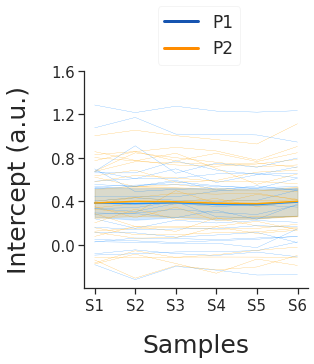

In [190]:
plt.subplots(ncols = 1, figsize = (4,4))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.subj)#npar

mycol = ["#1654B0", "darkorange"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.subj ==i,:]
    sns.lineplot(x="stim", y="intercept", hue="nrep", 
                 palette= ["dodgerblue", "orange"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Intercept', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="intercept", hue="nrep",
             palette= ["dodgerblue", "orange"], data=log_regstim_params)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('Intercept (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) 
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2']; 
plt.legend(lines, labels, bbox_to_anchor=(0.29,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
#plt.savefig('sample_intercept4part.png',bbox_inches='tight')

<font size="4"> Statistical tests for Inercept

In [191]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'subj', 
            data=log_regstim_params, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.799312,1,24,0.799312,9.242425,0.005640,0.005640,0.278031,1.000000
1,stim,1.431788,5,120,0.286358,1.867992,0.104930,0.138729,0.072213,0.636480
2,nrep * stim,0.541402,5,120,0.108280,1.641327,0.154241,0.163077,0.064011,0.886655


In [1948]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'subj', 
            data=log_regstim_params, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.000762,1,19,0.000762,0.008081,0.929313,0.929313,0.000425,1.000000
1,stim,0.026105,5,95,0.005221,1.486875,0.201360,0.222203,0.072577,0.685336
2,nrep * stim,0.002270,5,95,0.000454,0.303541,0.909663,0.880941,0.015725,0.830365


<font size="2"> _There were non statisitcal differences in sample position and intercept._

<font size="5"> _Figure 5 A & B. Category similarity between consecutive samples._

Logisitc regression model with the category of the previous stimuli sample

In [192]:
# First, build a logistic model with presentations and the category of previous sample

dflong_seq_clean = dflong_seq[(dflong_seq.subj != 's16') & (dflong_seq.subj != 's22') &  (dflong_seq.subj != 's10')]

formula = "deci ~ dv"

log_regpre_deci_params = dflong_seq_clean.groupby(['subj', 'cong_stim_DV','cong_stim_OV']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

,subj,cong_stim_DV,cong_stim_OV,level_3,intercept,weight,PSE
0,s01,0,0,0,0.357110,1.990057,-0.179447
1,s01,0,1,0,0.691819,0.894296,-0.773591
2,s01,1,0,0,0.473572,0.762977,-0.620689
3,s01,1,1,0,0.691848,-0.368531,1.877314
4,s02,0,0,0,0.184827,1.711551,-0.107988


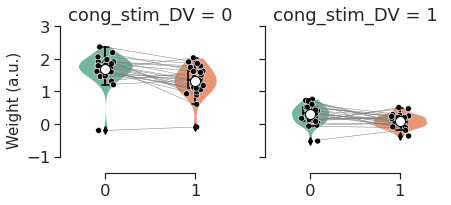

In [193]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
dat = log_regpre_deci_params

ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_stim_OV"; dy = "weight"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col = 'cong_stim_DV',  height= 3.5, aspect=.95,margin_titles=True) # col="nrep",
g.set(ylim=[-1.5,3], yticks=[-1, 0, 1, 2, 3])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


#g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
#g._margin_titles_texts[0].set_text("Cardinal")
#g._margin_titles_texts[0].set_size("20")
#g._margin_titles_texts[1].set_text("Diagonal")
#g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Weight (a.u.)", fontsize = 15 )
#g.tight_layout()


<font size="4"> Statistical tests for Beta Weight

In [195]:
#Checking statistical differences in Weight between the number of repetitions & the previous sample category
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

pg.rm_anova(dv = 'weight', within = ['cong_stim_DV','cong_stim_OV'], subject = 'subj', 
            data=log_regpre_deci_params, detailed = True, correction = True)

#Weight was larger in those samples that followed a sample from the same category

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cong_stim_DV,42.643347,1,24,42.643347,361.842345,5.568931e-16,5.568931e-16,0.937798,1.0
1,cong_stim_OV,2.114276,1,24,2.114276,20.947825,1.217951e-04,1.217951e-04,0.466048,1.0
2,cong_stim_DV * cong_stim_OV,0.193694,1,24,0.193694,4.717515,3.996316e-02,3.996316e-02,0.164273,1.0


Post-hoc t-test

In [80]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV','nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen',interaction=False, data=log_regpre_deci_params) 

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,cong_stim_DV,0,1,True,True,20.184512,25.0,two-sided,5.445966e-17,NaN,NaN,8.871e+13,5.432877
1,nrep,0,1,True,True,-1.740900,25.0,two-sided,9.399685e-02,0.281991,bonf,0.775,-0.263926
2,nrep,0,2,True,True,-4.099558,25.0,two-sided,3.835183e-04,0.001151,bonf,80.21,-0.585831
3,nrep,1,2,True,True,-2.694831,25.0,two-sided,1.240575e-02,0.037217,bonf,3.939,-0.288705


In [82]:
# post-hoc t-test for P1
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 0] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,cong_stim_DV,0,1,True,True,21.841237,25.0,two-sided,8.392776e-18,5.298e+14,6.190066


In [83]:
# post-hoc t-test for P2
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 1] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,cong_stim_DV,0,1,True,True,17.135181,25.0,two-sided,2.502906e-15,2.298e+12,4.568467


In [84]:
# post-hoc t-test for P3
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 2] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,cong_stim_DV,0,1,True,True,18.942506,25.0,two-sided,2.425581e-16,2.13e+13,4.898787


<font size="5"> _5B. Intercept._

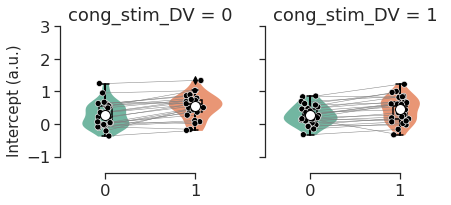

In [196]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
dat = log_regpre_deci_params

ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_stim_OV"; dy = "intercept"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col = 'cong_stim_DV',  height= 3.5, aspect=.95,margin_titles=True) # col="nrep",
g.set(ylim=[-1.5,3], yticks=[-1, 0, 1, 2, 3])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


#g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
#g._margin_titles_texts[0].set_text("Cardinal")
#g._margin_titles_texts[0].set_size("20")
#g._margin_titles_texts[1].set_text("Diagonal")
#g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Intercept (a.u.)", fontsize = 15 )
#g.tight_layout()


<font size="4"> Statistical tests for Inercept

In [53]:
#Checking statistical differences in Intercept between the number of repetitions 
# & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_stim'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

# no differences in the intercept

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.020666,2,52,0.010333,0.516653,0.599543,0.598899,0.019484,0.996376
1,pre_stim,0.349316,1,26,0.349316,8.969096,0.005960,0.005960,0.256486,1.000000
2,nrep * pre_stim,0.005757,2,52,0.002878,0.762662,0.471569,0.460285,0.028497,0.907134


In [54]:
pg.pairwise_ttests(dv='intercept', within=['pre_stim', 'nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=log_regpre_deci_params) 

,Contrast,pre_stim,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,pre_stim,-,0,1,True,True,2.994845,26.0,two-sided,0.005960,NaN,NaN,7.235,0.278307
1,nrep,-,0,1,True,True,0.977335,26.0,two-sided,0.337410,1.0,bonf,0.314,0.085460
2,nrep,-,0,2,True,True,0.649050,26.0,two-sided,0.521999,1.0,bonf,0.247,0.048439
3,nrep,-,1,2,True,True,-0.373029,26.0,two-sided,0.712151,1.0,bonf,0.217,-0.031116
4,pre_stim * nrep,0,0,1,True,True,1.271739,26.0,two-sided,0.214724,1.0,bonf,0.42,0.126499
5,pre_stim * nrep,0,0,2,True,True,0.815741,26.0,two-sided,0.422059,1.0,bonf,0.276,0.064534
6,pre_stim * nrep,0,1,2,True,True,-0.532817,26.0,two-sided,0.598686,1.0,bonf,0.232,-0.050571
7,pre_stim * nrep,1,0,1,True,True,0.447472,26.0,two-sided,0.658240,1.0,bonf,0.223,0.038672
8,pre_stim * nrep,1,0,2,True,True,0.344832,26.0,two-sided,0.732995,1.0,bonf,0.215,0.027723
9,pre_stim * nrep,1,1,2,True,True,-0.118930,26.0,two-sided,0.906245,1.0,bonf,0.205,-0.008887


In [55]:
# post-hoc t-test for P1

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==0]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_stim,0.0,1.0,True,True,3.001301,26.0,two-sided,0.005867,7.332,0.294823


In [56]:
# post-hoc t-test for P2

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==1]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_stim,0.0,1.0,True,True,2.830166,26.0,two-sided,0.008852,5.168,0.267804


In [57]:
# post-hoc t-test for P3

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==2]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_stim,0.0,1.0,True,True,2.483398,26.0,two-sided,0.019786,2.638,0.248507


<font size="5"> _Figure 5 C & D. Physical similarity between consecutive samples._

<font size="5"> _5C. Beta Weight._

Logisitc regression model with the physical similarity with previous sample

In [265]:
formula = "deci ~ dv"

log_regpre_orient_params = dflong_seq.groupby(['npar', 'nrep', 'cong_stim_OV']).apply(log_reg_fit, formula)
log_regpre_orient_params.reset_index(inplace = True)
log_regpre_orient_params.head()

,npar,nrep,cong_stim_OV,level_3,intercept,weight,PSE
0,1,0,0,0,0.516041,1.438844,-0.358650
1,1,0,1,0,0.576148,0.315760,-1.824637
2,1,1,0,0,0.299925,1.258117,-0.238392
3,1,1,1,0,0.748548,0.231713,-3.230501
4,2,0,0,0,0.137648,0.805389,-0.170909


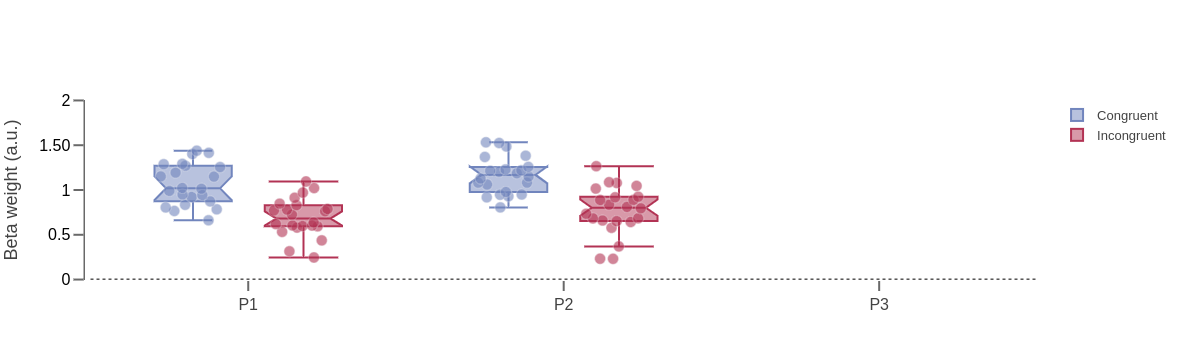

In [266]:
# Stimulus following one similar orientated (do not differ in many degrees) are weighted less than others
# preceded by stimuli from distant orientations.

fig = go.Figure()
data = log_regpre_orient_params

dat = log_regpre_orient_params.loc[(log_regpre_orient_params['cong_stim_OV'] == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another similar oriented
    y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another similar in orientation
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params['cong_stim_OV'] == 1),:]
fig.add_trace(go.Box( #condition for samples that follow stimuli pysichaly similar
    y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .5, 1, 1.50, 2], ticktext=['0', '0.5', '1', '1.50', '2'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.005])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [92]:
# Checking statistical differences in 
# Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_stim_OV'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.257873,2,50,0.128937,7.643737,0.001269,0.001736,0.234156,0.925437
1,cong_stim_OV,1.206203,1,25,1.206203,11.904366,0.002000,0.002000,0.322573,1.000000
2,nrep * cong_stim_OV,0.018020,2,50,0.009010,1.057409,0.354993,0.351333,0.040580,0.929771


In [61]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=log_regpre_orient_params) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0.0,1.0,True,True,-1.125617,26.0,two-sided,0.270611,0.811834,bonf,0.361,-0.160350
1,nrep,0.0,2.0,True,True,-4.335024,26.0,two-sided,0.000194,0.000583,bonf,145.935,-0.542633
2,nrep,1.0,2.0,True,True,-3.548843,26.0,two-sided,0.001498,0.004494,bonf,23.891,-0.316516
3,pre_orient,0.0,1.0,True,True,-6.280211,26.0,two-sided,0.000001,NaN,NaN,1.503e+04,-1.044517


Post-hoc t-test to look for interactions within categories

In [62]:
# post-hoc t-test for P1

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 0]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_orient,0.0,1.0,True,True,-5.305021,26.0,two-sided,0.000015,1474.949,-1.105405


In [63]:
# post-hoc t-test for P2

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 1]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_orient,0.0,1.0,True,True,-5.316472,26.0,two-sided,0.000015,1515.975,-0.893998


In [64]:
# post-hoc t-test for P3

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 2]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_orient,0.0,1.0,True,True,-5.988884,26.0,two-sided,0.000003,7548.418,-0.959297


<font size="5"> _5D. Intercept._

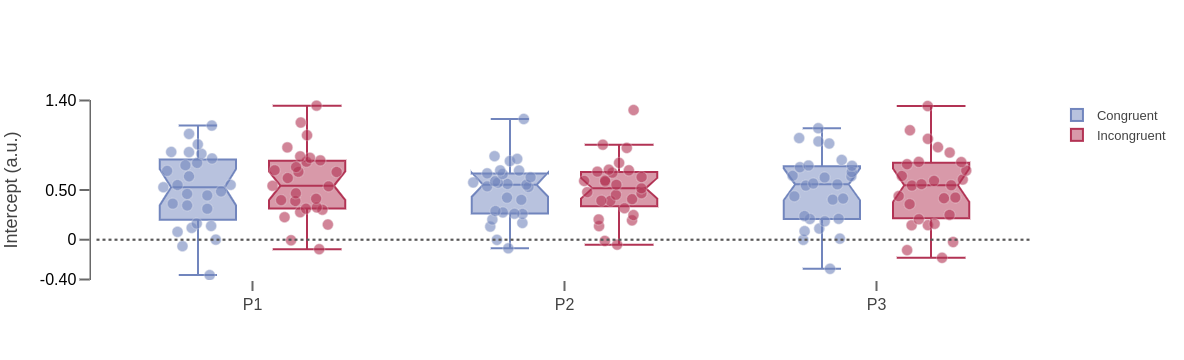

In [65]:
fig = go.Figure()

data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another pyshically similar
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4) ),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Intercept

In [531]:
#statistical test in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_orient'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

KeyError: 'pre_orient'

<font size="5"> _Supplementary Figure 1A. Beta Weight for physical similarity between stimuli samples and previous decisions._

Logisitc regression model with congruency with stimuli sample by each presentation

In [846]:
dflong.head()

,subj,blocktype,nblock,ntrial,nrep,stim_cond,cond-1,cong_deci,cong_stim,cond,deci-2,deci-1,deci,corr-1,correct,RT,stim,dv,orient,ov
0,s01,nonrepeat,0,0,0,D,0,I,I,1,0,0,1,0,1,2.044453,d1,0.828372,41.138370,-0.085814
1,s01,nonrepeat,0,0,0,C,0,C,C,1,0,0,1,0,1,2.044453,d2,-0.956710,0.974028,-0.978355
2,s01,nonrepeat,0,0,0,D,0,I,I,1,0,0,1,0,1,2.044453,d3,0.360338,120.607616,0.319831
3,s01,nonrepeat,0,0,0,C,0,C,C,1,0,0,1,0,1,2.044453,d4,-0.087842,110.523559,0.543921
4,s01,nonrepeat,0,0,0,D,0,I,I,1,0,0,1,0,1,2.044453,d5,0.939380,136.363955,-0.030310


In [853]:
np.unique(dflong.subj)

array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's12', 's13', 's14', 's15', 's16', 's17', 's19', 's20',
       's21', 's22', 's23', 's24', 's25'], dtype=object)

In [856]:
sj

's16'

In [197]:
formula = "deci ~ dv"
for sj in np.unique(dflong.subj):
    dat = dflong[dflong.subj == sj]
    log_reg_cong_stim = dat.groupby(['nrep', 'cong_deci', 'stim_cond','blocktype']).apply(log_reg_fit, formula) 
    log_reg_cong_stim.reset_index(inplace = True)
#    log_reg_cong_stim.head(5)

PerfectSeparationError: Perfect separation detected, results not available

In [201]:
isubj

's02'

In [206]:
formula = "deci ~ dv"

subjs = np.array(['s01', 's02', 's03', 's04', 's06', 's07', 's08', 's09',
      's11','s12', 's13', 's14', 's15', 's17', 's19', 's20',
       's21', 's23', 's24', 's25'])

for isubj in subjs:
    df_subj = dflong[( dflong.subj == isubj) ] # s16 does not converge
    log_reg_preDeci = df_subj.groupby(['nrep', 'cong_deci', 'stim_cond', 'blocktype']).apply(log_reg_fit, formula) 
    

In [208]:
df_subj = dflong[(dflong.subj != 's05') & (dflong.subj != 's16') & (dflong.subj != 's22') & (dflong.subj != 's10')] # s16 does not converge
formula = "deci ~ dv"
log_reg_cong_stim = df_subj.groupby(['subj','nrep', 'cong_deci', 'stim_cond']).apply(log_reg_fit, formula) 
log_reg_cong_stim.reset_index(inplace = True)
log_reg_cong_stim.head(5)

,subj,nrep,cong_deci,stim_cond,level_4,intercept,weight,PSE
0,s01,0,C,C,0,0.768104,1.120111,-0.685739
1,s01,0,C,D,0,0.081644,1.675498,-0.048728
2,s01,0,I,C,0,0.365506,0.391879,-0.932703
3,s01,0,I,D,0,0.074982,1.769408,-0.042377
4,s01,1,C,C,0,-0.868794,0.034216,25.391816


'\n# you can access different features of the plot nad panels using for loops\nfor (row_val, col_val), ax in g.axes_dict.items():\n    if row_val == "Lunch" and col_val == "Female":\n        ax.set_facecolor(".95")\n    else:\n        ax.set_facecolor((0, 0, 0, 0))\n#g.savefig("facet_plot.png")\n'

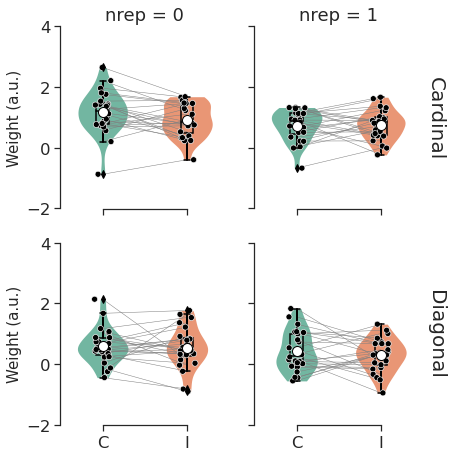

In [209]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
#dat = log_reg_cong_stim[ (log_reg_cong_stim.blocktype=='repeat')]
dat = log_reg_cong_stim #[ (log_reg_cong_stim['conf_lvl-1']=='H')]
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==1)]
#dat =  log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_deci"; dy = "weight"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col = 'nrep',  row= 'stim_cond', height= 3.5, aspect=.95,margin_titles=True) # col="nrep",
g.set(ylim=[-2,4], yticks=[-2, 0, 2, 4])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


#g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
g._margin_titles_texts[0].set_text("Cardinal")
g._margin_titles_texts[0].set_size("20")
g._margin_titles_texts[1].set_text("Diagonal")
g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Weight (a.u.)", fontsize = 15 )
#g.tight_layout()


'''
# you can access different features of the plot nad panels using for loops
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == "Lunch" and col_val == "Female":
        ax.set_facecolor(".95")
    else:
        ax.set_facecolor((0, 0, 0, 0))
#g.savefig("facet_plot.png")
'''

In [211]:
log_cong_scat = log_reg_cong_stim[ (log_reg_cong_stim.cong_deci == 'C')]
log_cong_scat.reset_index(inplace = True, drop = True)
inc = log_reg_cong_stim[ (log_reg_cong_stim.cong_deci == 'I')].iloc[:,6:9]
inc.reset_index(inplace=True, drop=True)
inc.columns = ['intercept_i', 'weight_i', 'PSE_i']
log_cong_scat = pd.concat([log_cong_scat, inc], axis = 1)
# renaming by index
new_names = ['intercept_c', 'weight_c', 'PSE_c']
old_names = log_cong_scat.columns[[6,7,8]]
log_cong_scat.rename(columns=dict(zip(old_names, new_names)), inplace=True)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 3 elements

In [1961]:
log_cong_scat_avg = log_cong_scat.groupby(['nrep','stim_cond', 'blocktype'],as_index=False)[['weight_i','weight_c']].mean()
log_cong_scat_se = log_cong_scat.groupby(['nrep','stim_cond', 'blocktype'],as_index=False)[['weight_i','weight_c']].sem()
log_cong_scat_avg['semi'] = log_cong_scat_se.weight_i
log_cong_scat_avg['semc'] = log_cong_scat_se.weight_c


KeyError: 'blocktype'

In [1487]:
datse

,nrep,stim_cond,blocktype,weight_i,weight_c,semi,semc
0,0,C,nonrepeat,0.970362,1.395596,0.095541,0.141323
1,0,C,repeat,1.006966,0.857122,0.159861,0.139067
2,0,D,nonrepeat,0.461823,0.792770,0.298811,0.154905
3,0,D,repeat,0.731273,0.775350,0.182476,0.161316
4,1,C,nonrepeat,0.858907,0.496643,0.178737,0.139477
5,1,C,repeat,0.938508,0.819319,0.152510,0.188607
6,1,D,nonrepeat,0.458656,0.750191,0.189977,0.266545
7,1,D,repeat,0.650652,0.828576,0.208776,0.328149


In [2055]:
#%matplotlib inline
mycol = ['#ffbf00' , '#00acc1'] 
sns.set(font_scale = 1.5, style = 'ticks') 
dat =log_reg_cong_stim[ (log_reg_cong_stim.nrep == 1)& (log_reg_cong_stim['conf_lvl-1'] =='L')]
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==0)& (log_reg_cong_stim.blocktype=='nonrepeat')]
#dat =  log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "weight_c"; dy = "weight_i"; ort = "v"; pal = pal; sigma = .5

g = sns.relplot(
    data=dat, kind='scatter', hue ='stim_cond',
    col='nrep', row='blocktype', x=dx, y=dy, units='subj',
    estimator=None, s = 30, height= 3.5, aspect=.95, alpha = 0.5)

def const_line(*args, **kwargs):
    x = np.arange(-2, 6, 2)
    y = x
    plt.plot(y, x,  ':', linewidth=2, color='grey', alpha = 0.5)

g.map(const_line, zorder = 4)
g.set(ylim=[-2,4], yticks=[-2, 0, 2, 4])
g.set(xlim=[-2,4], xticks=[-2, 0, 2, 4])
#sns.despine(offset = .5,  trim=True);
g.set_titles("")
g.fig.suptitle('Weights congruency')


# extract and flatten the axes from the figure
#axes = g.axes.flatten()

# iterate through each axes
for j in [0,1]: #for loop to compute the average by each participant
    for z in [0,1]:
        data = log_cong_scat_avg[(log_cong_scat_avg.blocktype == blocktype_labels[j]) & (log_cong_scat_avg.nrep == z)]
        datse = log_cong_scat_se[(log_cong_scat_se.blocktype == blocktype_labels[j]) & (log_cong_scat_se.nrep == z)]
        
        # plot the mean data
        g.axes[z,j].errorbar(dx, dy, data = data, yerr='semc', xerr='semi',
            fmt='None', color = 'black', capthick=2)
        
        sns.scatterplot(data=data, x=dx, y=dy, ax=g.axes[z,j], s = 80, hue='stim_cond', lw=6, zorder = 3)
        g.axes[z,j].set_xlabel('congruent weight  (a.u.)', fontdict={'size':15}, labelpad=5); 
        g.axes[z,j].set_ylabel('incongruent weight  (a.u.)', fontdict={'size':15}, labelpad=5); 
# fix the legends
        g.axes[z,j].axes.legend().remove()
        
       
        #plt.title(subtitle_string, fontsize=10)    
        
       # g.axes[z,j].legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper left')


ValueError: Could not interpret value `weight_c` for parameter `x`

In [2088]:

dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==1) & (log_reg_cong_stim['conf_lvl-1']=='L') ]


pg.rm_anova(dv = 'weight', within = ['cong_deci', 'stim_cond'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cong_deci,0.000139,1,18,0.000139,0.000522,0.982029,0.982029,0.000029,1.0
1,stim_cond,1.380655,1,18,1.380655,1.703855,0.208224,0.208224,0.086473,1.0
2,cong_deci * stim_cond,3.148299,1,18,3.148299,6.407773,0.020898,0.020898,0.262530,1.0


In [2068]:

dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==0) & (log_reg_cong_stim['conf_lvl-1']=='L') & (log_reg_cong_stim['blocktype']=='repeat')]


pg.rm_anova(dv = 'weight', within = ['cong_deci', 'stim_cond'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cong_deci,0.001368,1,18,0.001368,0.001139,0.973450,0.973450,0.000063,1.0
1,stim_cond,1.248484,1,18,1.248484,1.108726,0.306289,0.306289,0.058022,1.0
2,cong_deci * stim_cond,0.635977,1,18,0.635977,0.851181,0.368420,0.368420,0.045153,1.0


In [212]:
dat = log_reg_cong_stim[  (log_reg_cong_stim.stim_cond=='C')]



pg.rm_anova(dv = 'weight', within = ['cong_deci', 'nrep'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cong_deci,0.335960,1,23,0.335960,1.644002,0.212551,0.212551,0.066710,1.0
1,nrep,2.112879,1,23,2.112879,9.474203,0.005317,0.005317,0.291746,1.0
2,cong_deci * nrep,0.500274,1,23,0.500274,3.496837,0.074268,0.074268,0.131972,1.0


In [1967]:
dat = log_reg_cong_stim[  (log_reg_cong_stim.stim_cond=='C')]



pg.rm_anova(dv = 'weight', within = ['cong_deci', 'nrep'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cong_deci,0.058385,1,21,0.058385,0.278804,0.603021,0.603021,0.013102,1.0
1,nrep,1.714555,1,21,1.714555,7.879188,0.010563,0.010563,0.272833,1.0
2,cong_deci * nrep,0.787617,1,21,0.787617,6.265623,0.020639,0.020639,0.229799,1.0


In [219]:
dat = log_reg_cong_stim[  (log_reg_cong_stim.stim_cond=='C') & (log_reg_cong_stim.nrep==)]



pg.rm_anova(dv = 'weight', within = ['cong_deci'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

SyntaxError: invalid syntax (1853786428.py, line 1)

In [870]:
log_reg_cong_stim.head()

,subj,nrep,cong_deci,stim_cond,blocktype,level_5,intercept,weight,PSE
0,s01,0,C,C,nonrepeat,0,1.265294,1.528128,-0.828003
1,s01,0,C,C,repeat,0,0.411237,0.969685,-0.424094
2,s01,0,C,D,nonrepeat,0,-0.015819,1.460408,0.010832
3,s01,0,C,D,repeat,0,0.144414,1.942096,-0.074360
4,s01,0,I,C,nonrepeat,0,0.243663,0.448098,-0.543771


In [956]:
diff_cong_stim = log_reg_cong_stim[log_reg_cong_stim['cong_deci'] == 'C'].copy()
diff_cong_stim.reset_index(inplace = True, drop = True)
s = log_reg_cong_stim[log_reg_cong_stim['cong_deci'] == 'I'].iloc[:,[6,7,8]].copy()
s.reset_index(inplace = True, drop = True)

diff_cong_stim.iloc[:,[6,7,8]] = diff_cong_stim.iloc[:,[6,7,8]] - s

In [874]:
diff_cong_stim.head(5)

,subj,nrep,cong_deci,stim_cond,blocktype,level_5,intercept,weight,PSE
0,s01,0,C,C,nonrepeat,0,1.021631,1.080030,-0.284232
1,s01,0,C,C,repeat,0,-0.028141,0.632999,0.880916
2,s01,0,C,D,nonrepeat,0,-0.297635,-0.832070,0.133763
3,s01,0,C,D,repeat,0,0.511050,0.221769,-0.287480
4,s01,1,C,C,nonrepeat,0,-0.854171,0.120441,2.624266


In [750]:
from sklearn.mixture import GaussianMixture

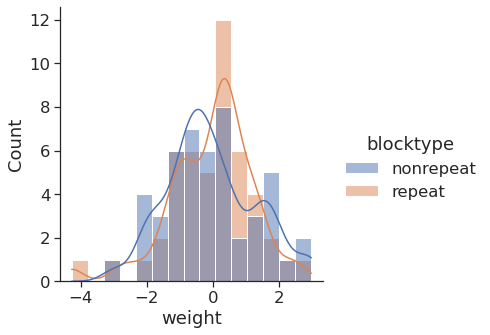

In [933]:
dat = diff_cong_stim[ (diff_cong_stim.nrep==1) ]
sns.displot(data = dat,  x = "weight", kde=True, 
             bins=int(15),  kde_kws =  {'bw_adjust' : 0.6}, hue = 'blocktype')
#sns.kdeplot(data = diff_cong_stim,  x = "weight", hue = 'blocktype',  bw_adjust=0.5)

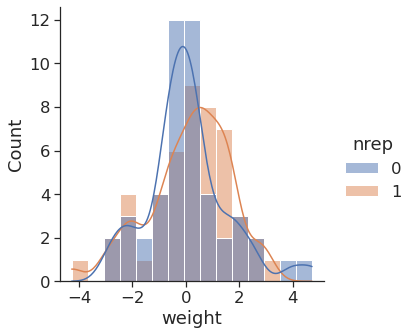

In [973]:
dat = diff_cong_stim[  (diff_cong_stim.stim_cond =="D") ]
sns.displot(data = dat,  x = "weight", kde=True, 
             bins=int(15),  kde_kws =  {'bw_adjust' : 0.6}, hue = 'nrep')
#sns.kdeplot(data = diff_cong_stim,  x = "weight", hue = 'blocktype',  bw_adjust=0.5)

Testing for normality of distributions

In [966]:
from scipy import stats
dat = diff_cong_stim[ (diff_cong_stim.nrep==0) & (diff_cong_stim.blocktype == 'nonrepeat')]
stats.shapiro(dat.weight)

ShapiroResult(statistic=0.9365904927253723, pvalue=0.012025500647723675)

In [972]:
stats.shapiro(diff_cong_stim[  (diff_cong_stim.stim_cond =="D")].weight) 

ShapiroResult(statistic=0.9873793125152588, pvalue=0.4937008321285248)

Fitting a bimodal gaussian mixture model

In [787]:
data = np.array(diff_cong_stim[(diff_cong_stim.blocktype == 'repeat')].weight).reshape(-1,1)
clf = GaussianMixture(n_components=2,  random_state=0)
clf.fit(data)

GaussianMixture(n_components=2, random_state=0)

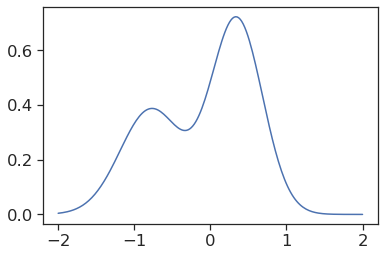

In [788]:
x = np.array(np.linspace(-2,2,200)).reshape(-1,1)
y = clf.score_samples(x)

plt.plot(x, np.exp(y))
plt.show()

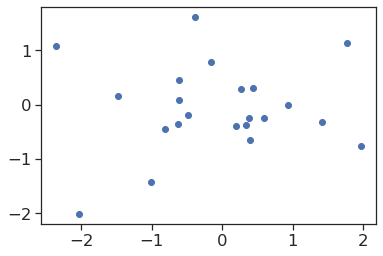

In [600]:
plt.scatter(diff_cong_stim[(diff_cong_stim.stim_cond == 'D') & (diff_cong_stim.blocktype == 'nonrepeat') ].weight, diff_cong_stim[(diff_cong_stim.stim_cond == 'C') &  (diff_cong_stim.blocktype == 'nonrepeat')].weight)

In [894]:
diff_cong_stim.head()

,subj,nrep,cong_deci,stim_cond,blocktype,level_5,intercept,weight,PSE
0,s01,0,C,C,nonrepeat,0,1.021631,1.080030,-0.284232
1,s01,0,C,C,repeat,0,-0.028141,0.632999,0.880916
2,s01,0,C,D,nonrepeat,0,-0.297635,-0.832070,0.133763
3,s01,0,C,D,repeat,0,0.511050,0.221769,-0.287480
4,s01,1,C,C,nonrepeat,0,-0.854171,0.120441,2.624266


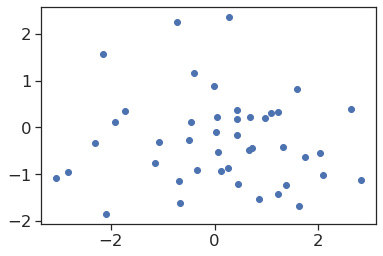

In [906]:
rep = 1
btype = 'repeat'
plt.scatter(diff_cong_stim[(diff_cong_stim.nrep == rep) & (diff_cong_stim.stim_cond == 'D') ].weight, diff_cong_stim[(diff_cong_stim.nrep == rep) & (diff_cong_stim.stim_cond == 'C') ].weight)

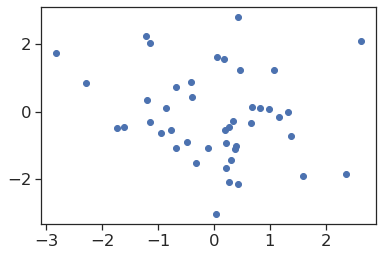

In [910]:
rep = 1

plt.scatter(diff_cong_stim[(diff_cong_stim.nrep == rep) & (diff_cong_stim.blocktype == 'repeat') ].weight, diff_cong_stim[(diff_cong_stim.nrep == rep) &   (diff_cong_stim.blocktype == 'nonrepeat')].weight)

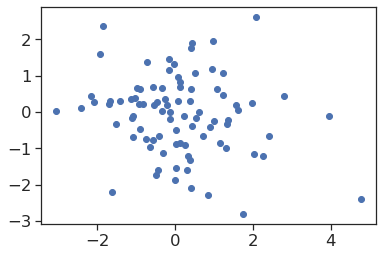

In [907]:
plt.scatter(diff_cong_stim[ (diff_cong_stim.blocktype == 'nonrepeat') ].weight, diff_cong_stim[ (diff_cong_stim.blocktype == 'repeat')].weight)

In [321]:
diff_preDeci = log_reg_preDeci[log_reg_preDeci['deci-1'] == 1].copy()
diff_preDeci.reset_index(inplace = True, drop = True)
s = log_reg_preDeci[log_reg_preDeci['deci-1'] == 0].iloc[:,[5,6,7]].copy()
s.reset_index(inplace = True, drop = True)

diff_preDeci.iloc[:,[5,6,7]] = diff_preDeci.iloc[:,[5,6,7]] - s

In [558]:
log_reg_cong_stim

,npar,cong_deci,stim_cond,level_3,intercept,weight,PSE
0,1,C,C,0,-0.113619,0.491411,0.231209
1,1,C,D,0,0.714410,1.027759,-0.695115
2,1,I,C,0,0.772073,0.471966,-1.635866
3,1,I,D,0,-0.106543,1.074717,0.099136
4,2,C,C,0,-0.180017,1.370847,0.131318
...,...,...,...,...,...,...,...
83,24,I,D,0,-0.243399,1.195117,0.203661
84,25,C,C,0,-0.900675,0.219395,4.105273
85,25,C,D,0,0.793011,0.735978,-1.077493
86,25,I,C,0,0.985682,0.960804,-1.025893


In [987]:
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==1) & (log_reg_cong_stim.blocktype=='repeat')]
dat = log_reg_cong_stim[  (log_reg_cong_stim.nrep==1) ]

pg.rm_anova(dv = 'weight', within = ['cong_deci','stim_cond'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cong_deci,0.014566,1,23,0.014566,0.075154,0.786422,0.786422,0.003257,1.0
1,stim_cond,0.781525,1,23,0.781525,1.058034,0.314361,0.314361,0.043978,1.0
2,cong_deci * stim_cond,0.800404,1,23,0.800404,2.332705,0.140318,0.140318,0.092083,1.0


In [536]:
dat

,npar,cong_deci,stim_cond,blocktype,level_4,intercept,weight,PSE
1,1,C,C,repeat,0,-0.486864,0.331077,1.470547
3,1,C,D,repeat,0,0.955933,1.706084,-0.560309
5,1,I,C,repeat,0,1.107319,0.420263,-2.634825
7,1,I,D,repeat,0,-0.486722,0.895085,0.543772
9,2,C,C,repeat,0,-0.351653,1.214486,0.289549
...,...,...,...,...,...,...,...,...
167,24,I,D,repeat,0,-0.072114,0.156046,0.462134
169,25,C,C,repeat,0,-1.091647,0.112209,9.728723
171,25,C,D,repeat,0,0.826144,0.672943,-1.227659
173,25,I,C,repeat,0,1.170882,1.356412,-0.863220


In [550]:
dat = log_reg_cong_stim #[(log_reg_cong_stim.stim_cond == 'C') ]

pg.rm_anova(dv = 'weight', within = ['cong_deci' , 'blocktype'], subject = 'npar', data=dat, detailed = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cong_deci,0.167433,1,21,0.167433,0.906641,0.351839,0.351839,0.041387,1.0
1,blocktype,0.098390,1,21,0.098390,0.647893,0.429886,0.429886,0.029929,1.0
2,cong_deci * blocktype,0.001293,1,21,0.001293,0.006847,0.934839,0.934839,0.000326,1.0


In [529]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.stim_cond == 'C') 
pg.rm_anova(dv = 'weight', within = ['cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

SyntaxError: invalid syntax (2563742714.py, line 2)

In [487]:
g.margin_title[0]


AttributeError: 'FacetGrid' object has no attribute 'margin_title'

In [ ]:
for margin_title in grid._margin_titles_texts:
    margin_title.set_color("red")

In [374]:
looking_outliers = log_reg_cong_stim.loc[log_reg_cong_stim.nrep == 2]
looking_outliers.tail(6)

,npar,cong_deci,nrep,cond,level_4,intercept,weight,PSE
298,28,I,2,0,0,0.020161,-1.803439,0.011179
299,28,I,2,1,0,1.689875,-2.225479,0.759331
304,29,C,2,0,0,0.004868,2.145449,-0.002269
305,29,C,2,1,0,0.956274,1.014332,-0.942763
310,29,I,2,0,0,0.197833,-2.262122,0.087455
311,29,I,2,1,0,0.379394,-1.449773,0.261692


In [515]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
#fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))
#fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))
#fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], boxpoints='all',
    jitter=.99, pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['weight'], x=dat['cong_deci'], opacity = 1, showlegend=False, boxpoints='all',
    jitter=.99, pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(  y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( 
    y=dat['weight'], x=dat['cong_deci'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_yaxes(showgrid=False)

fig.update_layout(yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

#fig['layout']['yaxis1'].update(range=[-1.005, 2.51]); fig['layout']['yaxis2'].update(range=[-1.005, 2.51])
#fig['layout']['yaxis3'].update(range=[-1.005, 2.51])

fig.show()

AttributeError: 'DataFrame' object has no attribute 'cond'

<font size="4"> Statistical tests for Beta Weight

In [483]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.stim_cond == 'C') & (log_reg_cong_stim.nrep != 0)]
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.206328,1,25,0.206328,0.490596,0.490129,0.490129,0.019246,1.0
1,cong_deci,4.849159,1,25,4.849159,8.737506,0.006711,0.006711,0.258985,1.0
2,nrep * cong_deci,0.000476,1,25,0.000476,0.001535,0.969058,0.969058,0.000061,1.0


In [71]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,nrep,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,-,0,1,True,True,11.070187,26.0,two-sided,2.450018e-11,7.350053e-11,bonf,3.736e+08,2.233195
1,nrep,-,0,2,True,True,8.199577,26.0,two-sided,1.110960e-08,3.332881e-08,bonf,1.173e+06,1.874948
2,nrep,-,1,2,True,True,-0.839986,26.0,two-sided,4.085745e-01,1.000000e+00,bonf,0.281,-0.120581
3,cong_stim,-,C,I,True,True,-0.430513,26.0,two-sided,6.703707e-01,NaN,NaN,0.222,-0.115840
4,nrep * cong_stim,0,C,I,True,True,-1.305173,26.0,two-sided,2.032672e-01,6.098015e-01,bonf,0.437,-0.382671
5,nrep * cong_stim,1,C,I,True,True,0.286044,26.0,two-sided,7.771112e-01,1.000000e+00,bonf,0.212,0.081996
6,nrep * cong_stim,2,C,I,True,True,-0.097211,26.0,two-sided,9.233044e-01,1.000000e+00,bonf,0.205,-0.025444


In [72]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cong_stim == 'C'),:]
pg.rm_anova(dv = 'weight', within = ['cond'], subject = 'npar', data=dat, detailed = True, correction = True)

,Source,SS,DF,MS,F,p-unc,np2,eps
0,cond,3.517647,1,3.517647,19.769313,0.000145,0.431934,1.0
1,Error,4.626302,26,0.177935,NaN,NaN,NaN,NaN


<font size="5"> _Supplementary Figure 1B. Intercept for Physical similarity between stimuli samples and previous decisions._

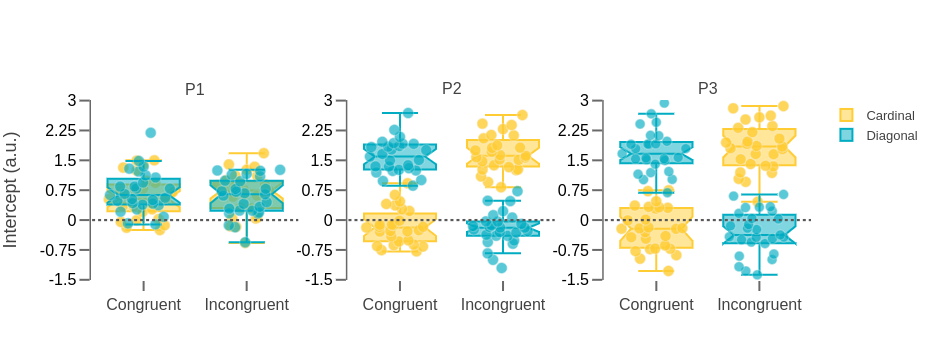

In [73]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal',
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=10,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.5,-0.75, 0, 0.75, 1.5, 2.25, 3], 
                 ticktext=['-1.5','-0.75', '0', '0.75', '1.5' ,'2.25', '3'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.505, 3.015]); fig['layout']['yaxis2'].update(range=[-1.505, 3.015])
fig['layout']['yaxis3'].update(range=[-1.505, 3.015],)

fig.show()

<font size="4"> Statistical tests for Intercept

In [74]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_stim'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.106604,2,52,0.053302,1.405071,2.545089e-01,2.548169e-01,0.051270,0.932192
1,cong_stim,71.439302,1,26,71.439302,342.787419,1.704312e-16,1.704312e-16,0.929499,1.000000
2,nrep * cong_stim,29.185073,2,52,14.592537,194.679087,7.104220e-25,8.008772e-21,0.882182,0.820243


In [75]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,nrep,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,-,0,1,True,True,-1.423697,26.0,two-sided,1.664252e-01,4.992756e-01,bonf,0.502,-0.117921
1,nrep,-,0,2,True,True,-1.466176,26.0,two-sided,1.545916e-01,4.637747e-01,bonf,0.529,-0.133234
2,nrep,-,1,2,True,True,-0.365952,26.0,two-sided,7.173619e-01,1.000000e+00,bonf,0.217,-0.032899
3,cong_stim,-,C,I,True,True,18.514519,26.0,two-sided,1.704312e-16,NaN,NaN,3.044e+13,2.954235
4,nrep * cong_stim,0,C,I,True,True,1.250214,26.0,two-sided,2.223572e-01,6.670715e-01,bonf,0.411,0.268860
5,nrep * cong_stim,1,C,I,True,True,21.684017,26.0,two-sided,3.566698e-18,1.070009e-17,bonf,1.23e+15,4.279840
6,nrep * cong_stim,2,C,I,True,True,22.650209,26.0,two-sided,1.213097e-18,3.639292e-18,bonf,3.456e+15,3.767159


<font size="5"> _Figure 6A. Beta Weight for Categorical similarity between stimuli samples and previous decisions._

<font size="3"> _Logisitc regression model to plot Figure 6_

In [76]:
formula = "deci ~ dv"
log_reg_cong_deci = dflong.groupby(['npar', 'cong_deci', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_deci.reset_index(inplace = True)
log_reg_cong_deci.head()

,npar,cong_deci,nrep,cond,level_4,intercept,weight,PSE
0,1.0,C,0,C,0,0.195054,0.571804,-0.341120
1,1.0,C,0,D,0,0.530885,1.448131,-0.366600
2,1.0,C,1,C,0,-1.567359,0.202153,7.753317
3,1.0,C,1,D,0,1.644346,1.427259,-1.152101
4,1.0,C,2,C,0,-1.282753,0.670489,1.913161


Figure 6A

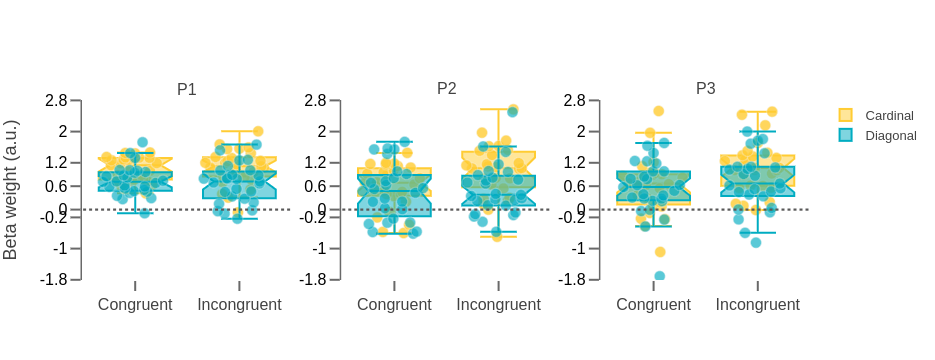

In [77]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal',
    marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], 
                 ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [78]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,2.249762,2,52,1.124881,4.725408,0.013013,0.017580,0.153795,0.862711
1,cong_deci,3.756905,1,26,3.756905,8.257388,0.007982,0.007982,0.241040,1.000000
2,nrep * cong_deci,1.637936,2,52,0.818968,2.925429,0.062522,0.066848,0.101137,0.929404


In [79]:
dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2),:]
pg.pairwise_ttests(dv='weight', within= ['cond', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,cond,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,cond,-,C,D,True,True,1.041703,26.0,two-sided,0.307139,NaN,NaN,0.333,0.262851
1,cong_deci,-,C,I,True,True,-2.255165,26.0,two-sided,0.032768,NaN,NaN,1.746,-0.649987
2,cond * cong_deci,C,C,I,True,True,-2.574830,26.0,two-sided,0.016072,0.032143,bonf,3.134,-0.712635
3,cond * cong_deci,D,C,I,True,True,-1.132627,26.0,two-sided,0.267708,0.535417,bonf,0.363,-0.333281


In [80]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,1.954473,26.0,two-sided,0.061479,0.184437,bonf,1.058,0.499663
1,nrep,0,2,True,True,-0.003172,26.0,two-sided,0.997493,1.000000,bonf,0.204,-0.000868
2,nrep,1,2,True,True,-1.738290,26.0,two-sided,0.093991,0.281973,bonf,0.763,-0.377056
3,cong_deci,C,I,True,True,-0.926794,26.0,two-sided,0.362557,NaN,NaN,0.301,-0.234961


<font size="5"> _Figure 6B. Intercept for Categorical similarity between stimuli samples and previous decisions._

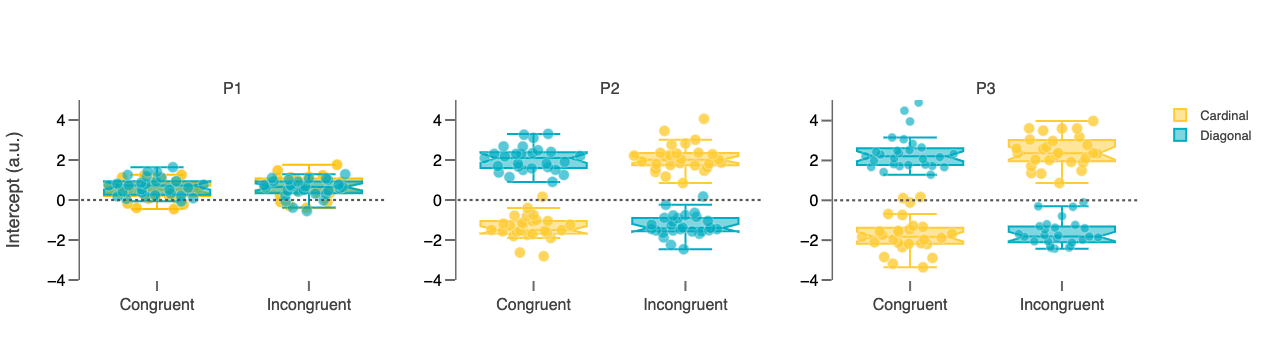

In [81]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=True, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal',marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=9,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))
fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Intercept (a.u.)", 
                  font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", 
                              font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-4, 5]); fig['layout']['yaxis2'].update(range=[-4, 5])
fig['layout']['yaxis3'].update(range=[-4, 5.034])

fig.show()

<font size="4"> Statistical tests for Intercept

In [82]:
# Cardinal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,1.636823,2,52,0.818411,4.140423,2.144984e-02,2.596399e-02,0.137371,0.892744
1,cong_deci,275.743248,1,26,275.743248,258.756344,4.966187e-15,4.966187e-15,0.908694,1.000000
2,nrep * cong_deci,124.524859,2,52,62.262430,168.648626,1.856830e-23,1.277561e-16,0.866426,0.676656


In [83]:
# Diagonal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,3.436114,2,52,1.718057,7.362840,1.529215e-03,2.454520e-03,0.220690,0.882641
1,cong_deci,265.394084,1,26,265.394084,205.854769,7.261261e-14,7.261261e-14,0.887861,1.000000
2,nrep * cong_deci,128.269370,2,52,64.134685,96.189332,3.360791e-18,5.051936e-13,0.787215,0.674975


In [84]:
dat1 = dat.loc[dat.nrep==2]
np.mean(dat1.intercept)

0.27519521493992277

In [85]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_deci'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,2.396753,26.0,two-sided,2.402315e-02,0.072069,bonf,2.249,0.557865
1,nrep,0,2,True,True,3.051665,26.0,two-sided,5.189772e-03,0.015569,bonf,8.143,0.501211
2,nrep,1,2,True,True,0.004395,26.0,two-sided,9.965272e-01,1.000000,bonf,0.204,0.001052
3,cong_deci,C,I,True,True,-16.085905,26.0,two-sided,4.966187e-15,NaN,NaN,1.215e+12,-4.983536


<font size="5"> _Figure 7. β Weight by Incongruent Samples minus β Weight by Congruent Samples divided by Ambiguous and Unambiguous samples and by Conditions._

- Ambiguous (DV = -0.3 to 0.3)
- Unambiguous (DV = 1 to -0.3 and 0.3 to 1)

<font size="3"> _Logisitc regression model to plot Figure 7_

In [86]:
new_dflong = dflong
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #this participants has not data for small bins

n_par = np.unique(new_dflong.npar)   #pre_deci
n_bins= np.array([-0.60, 0, 0.60])
log_reg_cong_bins = pd.DataFrame([]) # concatenate participants

formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins = pd.concat([log_reg_cong_bins, log_reg], axis = 0)
    
log_reg_cong_bins.reset_index(inplace = True)
log_reg_cong_bins.head(10)

,npar,nrep,cond,cong_deci,bins,level_5,intercept,weight,PSE
0,1.0,0,C,C,-0.6,0,0.202001,0.478565,-0.422097
1,1.0,0,C,I,-0.6,0,0.585941,0.970050,-0.604031
2,1.0,1,C,C,-0.6,0,-0.831635,1.202241,0.691737
3,1.0,1,C,I,-0.6,0,1.853114,1.028917,-1.801034
4,1.0,2,C,C,-0.6,0,-1.451881,0.402832,3.604187
5,1.0,2,C,I,-0.6,0,1.947116,0.957039,-2.034521
6,1.0,0,C,C,0.0,0,0.232816,1.057217,-0.220216
7,1.0,0,C,I,0.0,0,0.901060,0.924804,-0.974325
8,1.0,0,D,C,0.0,0,0.296233,1.780832,-0.166345
9,1.0,0,D,I,0.0,0,0.991398,-1.183951,0.837364


In [87]:
# first step: coding the new necessary variables  
# to substract β Weight in Congruent Samples to β Weight in Incongruent Samples

log_reg_cong_bins.insert(7,'intercept-1', 0)
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept']
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(9,'weight-1', 0)
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight']
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(8, 'bias', 0)
log_reg_cong_bins['bias'] = log_reg_cong_bins['intercept'] - log_reg_cong_bins['intercept-1']

log_reg_cong_bins.insert(10, 'slope', 0)
log_reg_cong_bins['slope'] = log_reg_cong_bins['weight'] - log_reg_cong_bins['weight-1']
log_reg_cong_bins.head()

,npar,nrep,cond,cong_deci,bins,level_5,intercept,intercept-1,bias,weight,slope,weight-1,PSE
0,1.0,0,C,C,-0.6,0,0.202001,0.000000,0.202001,0.478565,0.478565,0.000000,-0.422097
1,1.0,0,C,I,-0.6,0,0.585941,0.202001,0.383939,0.970050,0.491485,0.478565,-0.604031
2,1.0,1,C,C,-0.6,0,-0.831635,0.585941,-1.417575,1.202241,0.232191,0.970050,0.691737
3,1.0,1,C,I,-0.6,0,1.853114,-0.831635,2.684748,1.028917,-0.173324,1.202241,-1.801034
4,1.0,2,C,C,-0.6,0,-1.451881,1.853114,-3.304995,0.402832,-0.626085,1.028917,3.604187


In [88]:
# second step: drop unnecessary columns 
log_reg_cong_bins = log_reg_cong_bins.loc[(log_reg_cong_bins.cong_deci == 'I'),:]
log_reg_cong_bins = log_reg_cong_bins.drop(columns=['intercept-1', 'intercept', 'cong_deci', 
                                                    'weight', 'weight-1', 'PSE', 'level_5'])
log_reg_cong_bins.head()

,npar,nrep,cond,bins,bias,slope
1,1.0,0,C,-0.6,0.383939,0.491485
3,1.0,1,C,-0.6,2.684748,-0.173324
5,1.0,2,C,-0.6,3.398996,0.554207
7,1.0,0,C,0.0,0.668244,-0.132413
9,1.0,0,D,0.0,0.695165,-2.964783


In [89]:
# third step: convert the variable "bins" in a categorical variable
log_reg_cong_bins["bins"] = log_reg_cong_bins["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_cong_bins.head()

,npar,nrep,cond,bins,bias,slope
1,1.0,0,C,not_ambigu,0.383939,0.491485
3,1.0,1,C,not_ambigu,2.684748,-0.173324
5,1.0,2,C,not_ambigu,3.398996,0.554207
7,1.0,0,C,ambigu,0.668244,-0.132413
9,1.0,0,D,ambigu,0.695165,-2.964783


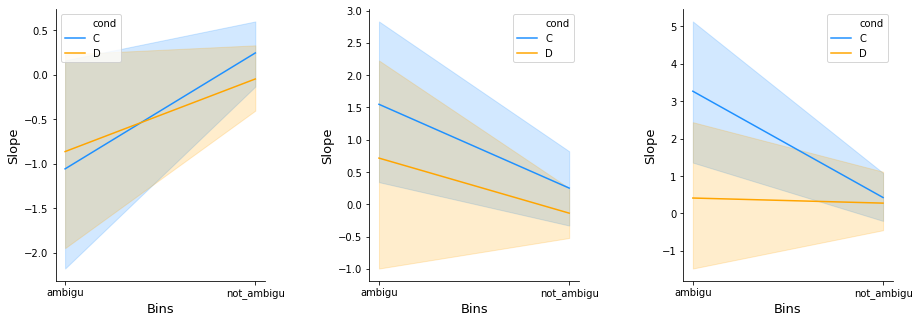

In [90]:
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

sns.despine(top=True)

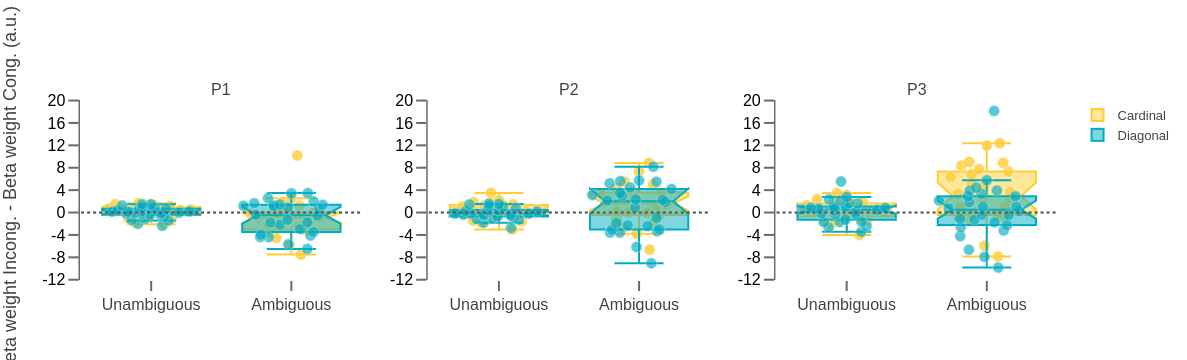

In [91]:
# final step: plot the data
from plotly.subplots import make_subplots
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], opacity = 0.8, x=dat['bins'], boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], boxpoints='all', showlegend=False, opacity = 1,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=3) 

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Unambiguous', 'Ambiguous'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], 
                 ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Beta weight Incong. - Beta weight Cong. (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif", size=13, color="#424242")))

fig['layout']['yaxis1'].update(range=[-12.05, 20.1]); fig['layout']['yaxis2'].update(range=[-12.05, 20.1])
fig['layout']['yaxis3'].update(range=[-12.05, 20.1])

fig.show()

<font size="4"> _Statistical tests_

Test whether differences in weight between congruent and incongruent samples with previous decisions depend by the ambiguity of the stimuli sample. 

<font size="2"> _t-test for unambiguous_

In [92]:
# t test for Cardinal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.2429,25,two-sided,0.2254,"[-0.16, 0.64]",0.2438,0.413,0.2231


In [93]:
# t test for Cardinal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.8903,25,two-sided,0.3818,"[-0.33, 0.83]",0.1746,0.297,0.1373


In [94]:
# t test for Cardinal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.2598,25,two-sided,0.2194,"[-0.27, 1.12]",0.2471,0.421,0.2279


In [95]:
# t test for Diagonal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.2522,25,two-sided,0.8029,"[-0.45, 0.35]",0.0495,0.213,0.0568


In [96]:
# t test for Diagonal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.6725,25,two-sided,0.5074,"[-0.55, 0.28]",0.1319,0.255,0.0992


In [97]:
# t test for Diagonal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.731,25,two-sided,0.4716,"[-0.5, 1.05]",0.1434,0.264,0.1083


<font size="2"> _t-test for ambiguous_

In [98]:
# t test for Cardinal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.6617,25,two-sided,0.1091,"[-2.37, 0.25]",0.3259,0.693,0.3589


In [99]:
# t test for Cardinal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.2758,25,two-sided,0.0317,"[0.15, 2.95]",0.4463,1.819,0.5902


In [100]:
# t test for Cardinal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep == 2),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.2932,25,two-sided,0.003,"[1.22, 5.31]",0.6459,13.372,0.8858


In [101]:
# t test for Diagonal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.5317,25,two-sided,0.1381,"[-2.02, 0.3]",0.3004,0.582,0.3135


In [102]:
# t test for Diagonal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.8562,25,two-sided,0.4,"[-1.01, 2.44]",0.1679,0.289,0.1306


In [103]:
# t test for Diagonal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.398,25,two-sided,0.694,"[-1.72, 2.55]",0.0781,0.223,0.067


Post-hoc t-test: one chunck for each presentation

In [104]:
# post-hoc t-test for P1
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==0]) 

,Contrast,bins,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,bins,-,not_ambigu,ambigu,True,True,3.662612,25.0,two-sided,0.001172,NaN,NaN,29.917,0.847750
1,cond,-,C,D,True,True,0.095074,25.0,two-sided,0.925014,NaN,NaN,0.208,0.029604
2,bins * cond,not_ambigu,C,D,True,True,1.123136,25.0,two-sided,0.272050,0.544101,bonf,0.365,0.293154
3,bins * cond,ambigu,C,D,True,True,-0.189045,25.0,two-sided,0.851584,1.000000,bonf,0.211,-0.063258


In [105]:
# post-hoc t-test for P2
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==1]) 

,Contrast,bins,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,bins,-,not_ambigu,ambigu,True,True,-2.093122,25.0,two-sided,0.046646,NaN,NaN,1.334,-0.550357
1,cond,-,C,D,True,True,1.025191,25.0,two-sided,0.315091,NaN,NaN,0.333,0.290866
2,bins * cond,not_ambigu,C,D,True,True,1.068622,25.0,two-sided,0.295450,0.590901,bonf,0.347,0.309386
3,bins * cond,ambigu,C,D,True,True,0.741926,25.0,two-sided,0.465046,0.930092,bonf,0.266,0.214317


In [106]:
# post-hoc t-test for P3
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==2]) 

,Contrast,bins,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,bins,-,not_ambigu,ambigu,True,True,-2.245352,25.0,two-sided,0.033832,NaN,NaN,1.725,-0.659875
1,cond,-,C,D,True,True,1.556510,25.0,two-sided,0.132157,NaN,NaN,0.602,0.521835
2,bins * cond,not_ambigu,C,D,True,True,0.333949,25.0,two-sided,0.741203,1.000000,bonf,0.218,0.081805
3,bins * cond,ambigu,C,D,True,True,1.686901,25.0,two-sided,0.104063,0.208126,bonf,0.718,0.551901
